# Intro:
This project aims at studying Order Cancellation tendencies for orders made in the hotel industry to help predict order importance and find patterns in customer behaviour.

### Methadology:
We followed a systematic method of tackling the problem by:
- Studying the Domain
- Asking Questions
- Pulling Data
  - From an SQL Database
- Data Pre-Proccessing
  - Adding columns (Ex: is_internal)
- Data Cleaning
- Data Distortion
- EDA
- Drawing Initial Conclusions
- Machinge Learning
- Asking More Questions
- Data Post-Proccessing
  - Adding more columns (Ex: Room_Nights, Review_Rating)
- More Machine Learning
- Final Conclusion

# Dataset:
 used a distorted subset of data acquired from a local business in the travel industry


## Description of Variables
The dataset contains 4238 observations of 21 variables:

### Features:

#### Pre-Processing:
1. Categoral Data:
 - guest_country_code:  
 Contains the country code of the source country of the order
 - destinationCountry:  
 Contains the destination code of the source country of the order
 - udid:                
 Contains customer udid
 - email:               
 Customer email address
 - phone:               
 Customer phone number
 - stars:               
 Specifies the properties' star rating (1->5)
 - hotel_id:            
 Hotel ID        
 - AvgUserRating:       
 Average user ratings for previous guests
 - type:                
 Property type
 - is_cardless:         
 Specifies if the payment method was "Cardless" or not (Boolean)
 - hasSpecialRequest:   
 Shows if the booking has a special request attached to it (Boolean) 
 - hasFreeCancellation: If booking has free cancellation option
 
 2. Non-Categoral:
  - roomCount:                   Total booking number of rooms
  - numberOfBookedNights:        Number of nights the booking has
  - numberOfReviews:             Amount of people that reviewed the property
  - NormalizedLowRate:           Price of the lowest room available at the property at the time of the booking
  - NormalizedTotalBookingPrice: Total booking price
  
#### Post-Processing:
 - Room_Nights:   numberOfBookedNights * roomCount
 - Review_Rating: AvgUserRating *  numberOfReviews
 - is_internal:   Shows if the booking was made from the same source and destination countries (Boolean)

 
### Target:
- cancelledOrNoShow: If the order was cancelled (or customer didn't show up) (Boolean)

## Importing the Packages

In [345]:
import math
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib.pyplot import pie, axis, show
from matplotlib import pyplot as plt
from matplotlib import cm as cm
%matplotlib inline



import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn import svm

import missingno as msno
!pip install chart_studio
from chart_studio import plotly
import chart_studio.plotly as py
import plotly.graph_objs as go
import lightgbm as ltb
!pip install catboost
import catboost as ctb

!pip install xgboost
import time
import xgboost as xgb
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import fbeta_score, make_scorer

# Reading the Data:

In [346]:
df = pd.read_csv('./distorted_data_extra_field.csv', sep=',')

## Data Preprocessing:
### Remove unneeded column

In [347]:
len(df)

4238

In [348]:
df.drop(df.columns[[0]], axis=1, inplace=True)

In [349]:
df.columns

Index(['destinationCountry', 'roomCount', 'udid', 'email', 'phone',
       'guest_country_code', 'is_cardless', 'stars', 'type',
       'NormalizedTotalBookingPrice', 'NormalizedLowRate',
       'numberOfBookedNights', 'numberOfReviews', 'AvgUserRating', 'hotel_id',
       'hasSpecialRequest', 'hasFreeCancellation', 'cancelledOrNoShow',
       'is_internal'],
      dtype='object')

In [350]:
df.head()

,destinationCountry,roomCount,udid,email,phone,guest_country_code,is_cardless,stars,type,NormalizedTotalBookingPrice,NormalizedLowRate,numberOfBookedNights,numberOfReviews,AvgUserRating,hotel_id,hasSpecialRequest,hasFreeCancellation,cancelledOrNoShow,is_internal
0,0,1.0,0,0,0,0,0,4.0,HOTEL,229.0,166.0,1,103.0,3.9643,0,0,1,0,1
1,1,2.0,1,1,1,0,0,1.0,HOTEL,126.0,90.0,2,10.0,1.0000,1,0,0,1,0
2,2,1.0,2,2,2,0,0,5.0,HOTEL,1722.0,753.0,4,25.0,3.8000,2,1,0,1,0
3,0,1.0,3,3,3,1,0,3.5,UNKNOWN,685.0,373.0,2,16.0,3.6000,3,0,0,0,0
4,2,1.0,0,4,4,2,0,5.0,HOTEL,427.0,401.0,1,10.0,5.0000,4,0,0,0,1


In [351]:
len(df)

4238

In [352]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
destinationCountry,4238.0,5.357480,7.891933,0.0,0.0000,2.000,8.0000,57.0
roomCount,4238.0,1.221095,0.635255,0.0,1.0000,1.000,1.0000,13.0
udid,4238.0,862.870694,862.418205,0.0,0.0000,640.500,1602.7500,2625.0
email,4238.0,1453.201982,1079.400480,0.0,440.2500,1387.500,2391.7500,3425.0
phone,4238.0,1934.479471,1151.241212,0.0,926.2500,1908.500,2927.7500,3971.0
guest_country_code,4238.0,3.039169,6.078425,0.0,0.0000,0.000,3.0000,50.0
is_cardless,4238.0,0.100047,0.300098,0.0,0.0000,0.000,0.0000,1.0
stars,4238.0,3.569962,1.413505,0.0,3.0000,4.000,4.5000,5.0
NormalizedTotalBookingPrice,4238.0,23992.322794,482250.391588,77.0,326.0000,713.000,1648.7500,25700521.0
NormalizedLowRate,4238.0,7123.140396,97182.274956,77.0,203.0000,373.000,615.0000,2655754.0


In [353]:
#Number of orders that have null values
df.isnull().values.sum()

0

<AxesSubplot:>

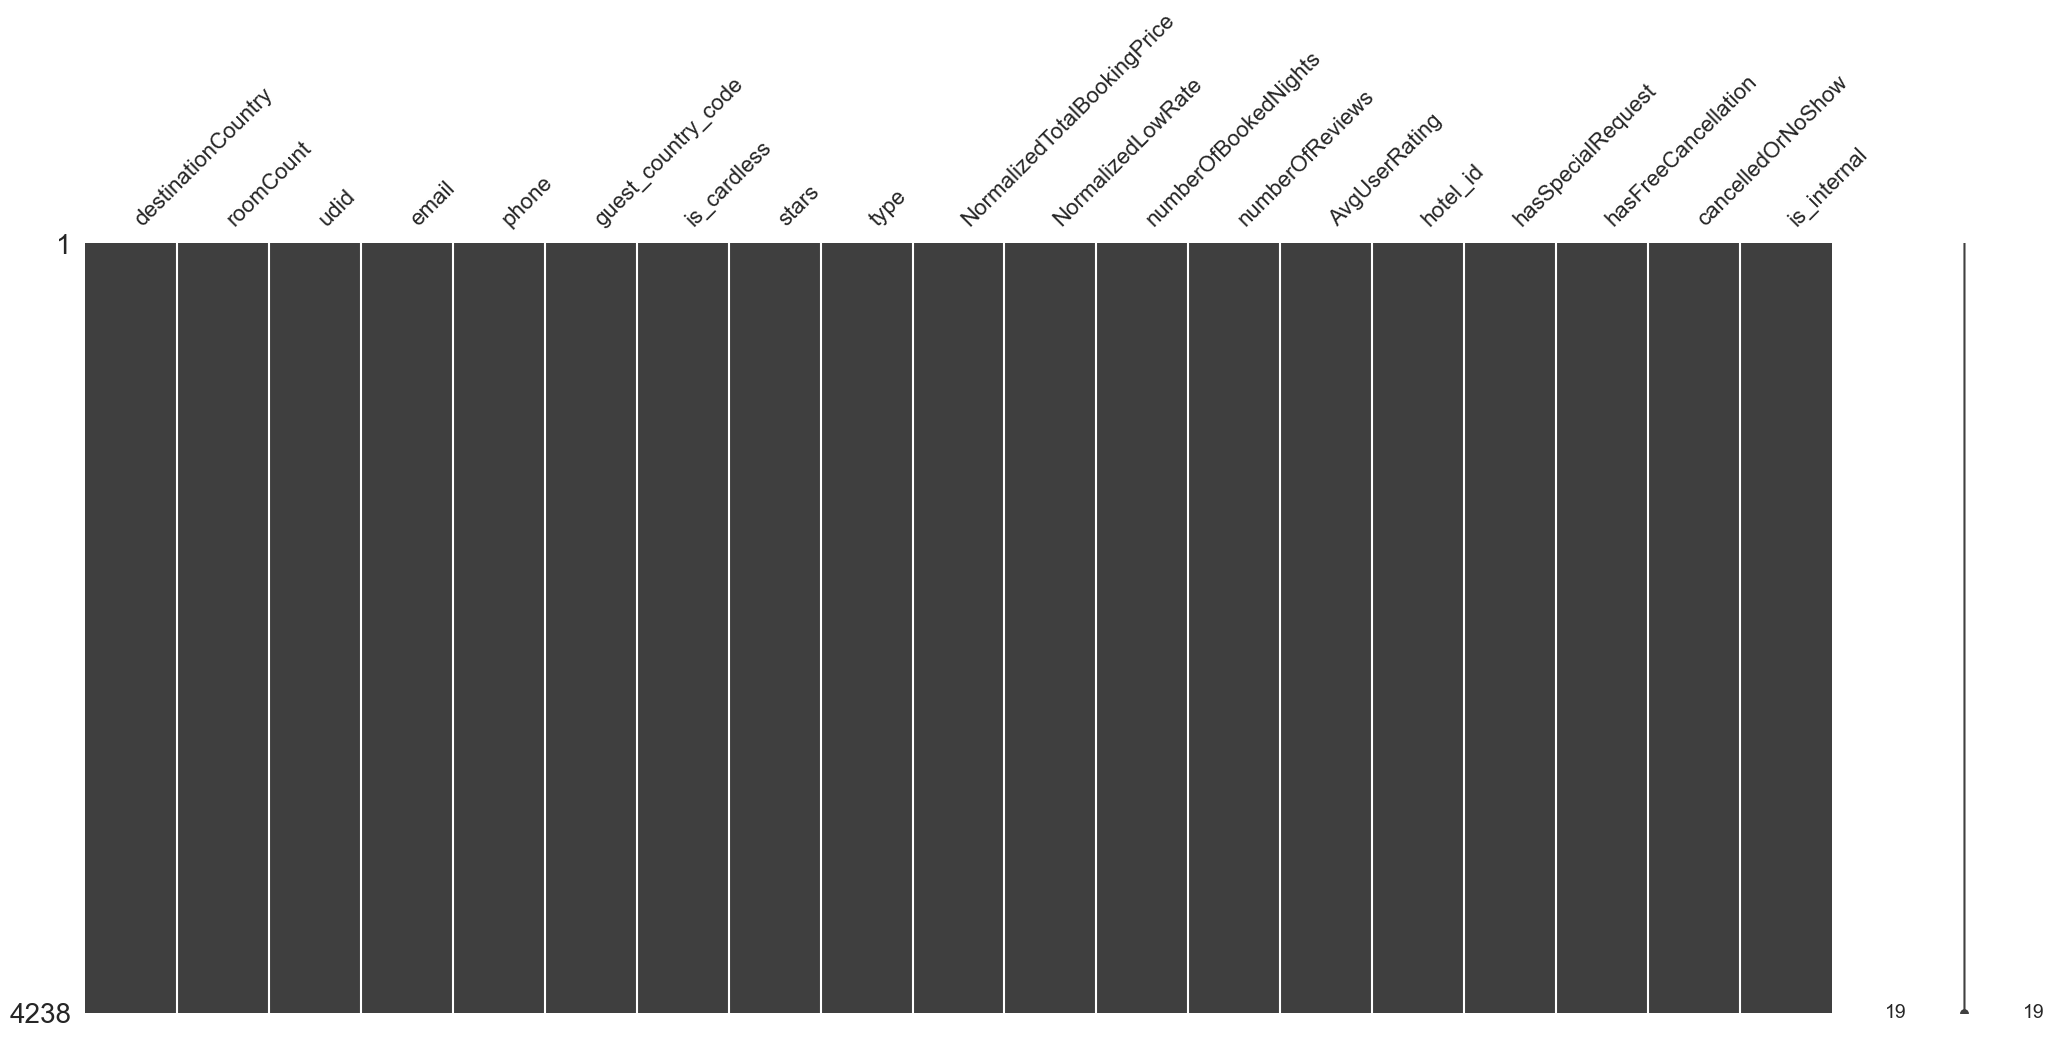

In [354]:
msno.matrix(df)

In [355]:
# Incrimenting ID values (to avoid keeping them as zeros)
def fillNA(data):
    data = np.array(data)
    toFloat = [float(floatValue) for floatValue in data]       #Convert to float
    biggestId = np.max(toFloat)                                #Find biggest id available (to avoid overlapping)
    print("Max id number available =", biggestId)
    
    for i in range (len(data)):
        if float(data[i]) == 0:
            data[i] = biggestId   
            biggestId = biggestId +1                           #Increment ID value
    return data

In [356]:
#Fill UDID missing data with correct values
udid = fillNA(df['udid'])
#df['udid'] = udid

Max id number available = 2625.0


In [357]:
#Check number of missing values after cleaning
df.fillna(0, inplace=True)

## Look for anomalies in the data

In [358]:
nullRooms         = df.loc[df['roomCount']            <= 0 ]
noReviews         = df.loc[df['numberOfReviews']      <= 0 ]
noNights          = df.loc[df['numberOfBookedNights'] <= 0 ]
noNights          = df.loc[df['numberOfBookedNights'] <= 0 ]
avgRating         = df.loc[df['AvgUserRating']        == 0 ]


print("Number of hotels with no reviews =",len(noReviews))
print("\nNumber of orders with no nights  =",len(noNights))
print('Number of orders with no rooms   =', len(nullRooms))


nullRooms.head()

Number of hotels with no reviews = 0

Number of orders with no nights  = 0
Number of orders with no rooms   = 3


,destinationCountry,roomCount,udid,email,phone,guest_country_code,is_cardless,stars,type,NormalizedTotalBookingPrice,NormalizedLowRate,numberOfBookedNights,numberOfReviews,AvgUserRating,hotel_id,hasSpecialRequest,hasFreeCancellation,cancelledOrNoShow,is_internal
1865,8,0.0,0,1558,1794,0,0,4.0,HOTEL,1059.0,228.0,6,10.0,5.0000,1042,0,0,1,0
2084,2,0.0,1347,1735,1991,0,0,4.0,HOTEL,8795.0,718.0,9,35.0,2.9375,1116,0,0,1,0
2620,10,0.0,0,2179,2495,0,0,5.0,HOTEL,5433.0,1088.0,9,13.0,4.3333,337,0,0,0,0


## Handle data anomalies by removing orders with rooms count = 0

In [359]:
indexes_to_drop = df[df['roomCount'] == 0].index.tolist()
df.drop(df.index[indexes_to_drop], inplace=True)

### Making sure all went well

In [360]:
nullRooms       = df.loc[df['roomCount']       == 0 ]

print('Number of orders with no rooms   =', len(nullRooms))

Number of orders with no rooms   = 0


### Round Average Reviews 

In [361]:
df['AvgUserRating'] = np.round(df['AvgUserRating'], decimals=0)
df['AvgUserRating'].head()

df['stars'] = np.round(df['stars'], decimals=0)
df['stars'][:20]

0     4.0
1     1.0
2     5.0
3     4.0
4     5.0
5     3.0
6     0.0
7     0.0
8     3.0
9     4.0
10    4.0
11    5.0
12    4.0
13    4.0
14    4.0
15    5.0
16    5.0
17    4.0
18    3.0
19    4.0
Name: stars, dtype: float64

## Create Dataframe for cancelled orders

In [362]:
cancelled = df.loc[df['cancelledOrNoShow'] == 1]
print(len(cancelled) / len(df) * 100)

32.585596221959854


In [363]:
print(df.isnull().values.sum())

0


## Add column for Internal Travel vs External Travel

In [364]:
def add_trip_type(df):
    is_internal = []
    count_same =0
    for i in range (len(df)):
        if (df['destinationCountry'][i] == df['guest_country_code'][i]):
            #print("\nSame\nDestination Country=", df['destinationCountry'][i], "\nSource Country     =", df['guest_country_code'][i])
            count_same += 1
            is_internal.append(1)
        else:
            is_internal.append(0)
    print(count_same/len(df) * 100)
    #return is_internal

In [365]:
#add_trip_type(df)

# Check Cancellation Tendency Based on Different Factors

In [366]:
destination = df[['destinationCountry', 'cancelledOrNoShow']].groupby(['destinationCountry'], as_index=False).mean().sort_values(by='cancelledOrNoShow', ascending=False)
destination[:20]

,destinationCountry,cancelledOrNoShow
49,49,1.000000
33,33,0.666667
38,38,0.666667
25,25,0.555556
28,28,0.500000
32,32,0.500000
20,20,0.428571
14,14,0.425000
53,53,0.400000
7,7,0.392857


In [367]:
source = df[['guest_country_code', 'cancelledOrNoShow']].groupby(['guest_country_code'], as_index=False).mean().sort_values(by='cancelledOrNoShow', ascending=False)
source[:20]

,guest_country_code,cancelledOrNoShow
32,32,1.000000
49,49,1.000000
48,48,1.000000
47,47,1.000000
46,46,1.000000
41,41,1.000000
38,38,1.000000
25,25,0.615385
24,24,0.500000
27,27,0.500000


In [368]:
property_type = df[['type', 'cancelledOrNoShow']].groupby(['type'], as_index=False).mean().sort_values(by='cancelledOrNoShow', ascending=False)
property_type[:20]

,type,cancelledOrNoShow
18,YAMSAFER_HOMES,1.000000
12,PENSION,1.000000
6,HOSTEL,1.000000
10,INN,0.571429
7,HOSTEL_BACKPACKER_ACCOMMODATION,0.555556
15,SUITE,0.478261
1,APARTMENT,0.454545
0,ALL_INCLUSIVE,0.416667
13,RESIDENCE,0.375000
17,VILLA,0.352941


In [369]:
reviews_number = df[['AvgUserRating', 'cancelledOrNoShow']].groupby(['AvgUserRating'], as_index=False).mean().sort_values(by='cancelledOrNoShow', ascending=False)
reviews_number

,AvgUserRating,cancelledOrNoShow
3,3.0,0.357955
0,0.0,0.357016
4,4.0,0.306306
1,1.0,0.297297
2,2.0,0.289116
5,5.0,0.251082


In [370]:
property_type = df[['stars', 'cancelledOrNoShow']].groupby(['stars'], as_index=False).mean().sort_values(by='cancelledOrNoShow', ascending=False)
property_type

,stars,cancelledOrNoShow
0,0.0,0.471178
2,2.0,0.372263
1,1.0,0.355556
3,3.0,0.352736
4,4.0,0.316362
5,5.0,0.256925


### 5 Star hotels have the lowest cancellation rate while unrated hotels have the highest rate

In [371]:
property_type = df[['hasSpecialRequest', 'cancelledOrNoShow']].groupby(['hasSpecialRequest'], as_index=False).mean().sort_values(by='cancelledOrNoShow', ascending=False)
property_type

,hasSpecialRequest,cancelledOrNoShow
0,0,0.329802
1,1,0.299639


### Looks like people who have a special request take their bookings more seriously

In [372]:
property_type = df[['hasFreeCancellation', 'cancelledOrNoShow']].groupby(['hasFreeCancellation'], as_index=False).mean().sort_values(by='cancelledOrNoShow', ascending=False)
property_type[:20]

,hasFreeCancellation,cancelledOrNoShow
1,1,0.408644
0,0,0.299658


### Hotels that provide free cancellation are more likely to have their bookings cancelled

In [373]:
property_type = df[['is_internal', 'cancelledOrNoShow']].groupby(['is_internal'], as_index=False).mean().sort_values(by='cancelledOrNoShow', ascending=False)
property_type[:20]

,is_internal,cancelledOrNoShow
1,1,0.345885
0,0,0.310185


### Internal bookings are more likelt to get cancelled than external

In [374]:
property_type = df[['is_cardless', 'cancelledOrNoShow']].groupby(['is_cardless'], as_index=False).mean().sort_values(by='cancelledOrNoShow', ascending=False)
property_type[:20]

,is_cardless,cancelledOrNoShow
1,1,0.471698
0,0,0.309630


### Cardless bookings get cancelled more than other payment methods

In [375]:
property_type = df[['numberOfBookedNights', 'cancelledOrNoShow']].groupby(['numberOfBookedNights'], as_index=False).mean().sort_values(by='cancelledOrNoShow', ascending=False)
property_type[:30]

,numberOfBookedNights,cancelledOrNoShow
30,31,1.000000
23,24,1.000000
28,29,1.000000
21,22,1.000000
29,30,1.000000
19,20,1.000000
18,19,1.000000
26,27,1.000000
16,17,0.666667
12,13,0.666667


In [376]:
property_type = df[['roomCount', 'cancelledOrNoShow']].groupby(['roomCount'], as_index=False).mean().sort_values(by='cancelledOrNoShow', ascending=False)
property_type[:30]

,roomCount,cancelledOrNoShow
8,10.0,1.000000
6,7.0,0.750000
5,6.0,0.666667
7,8.0,0.400000
2,3.0,0.329268
0,1.0,0.328981
1,2.0,0.304940
3,4.0,0.272727
4,5.0,0.142857
9,13.0,0.000000


## Some EDA on Cancelled Data 

In [377]:
cancelled_orders = df.loc[df['cancelledOrNoShow'] == 1]

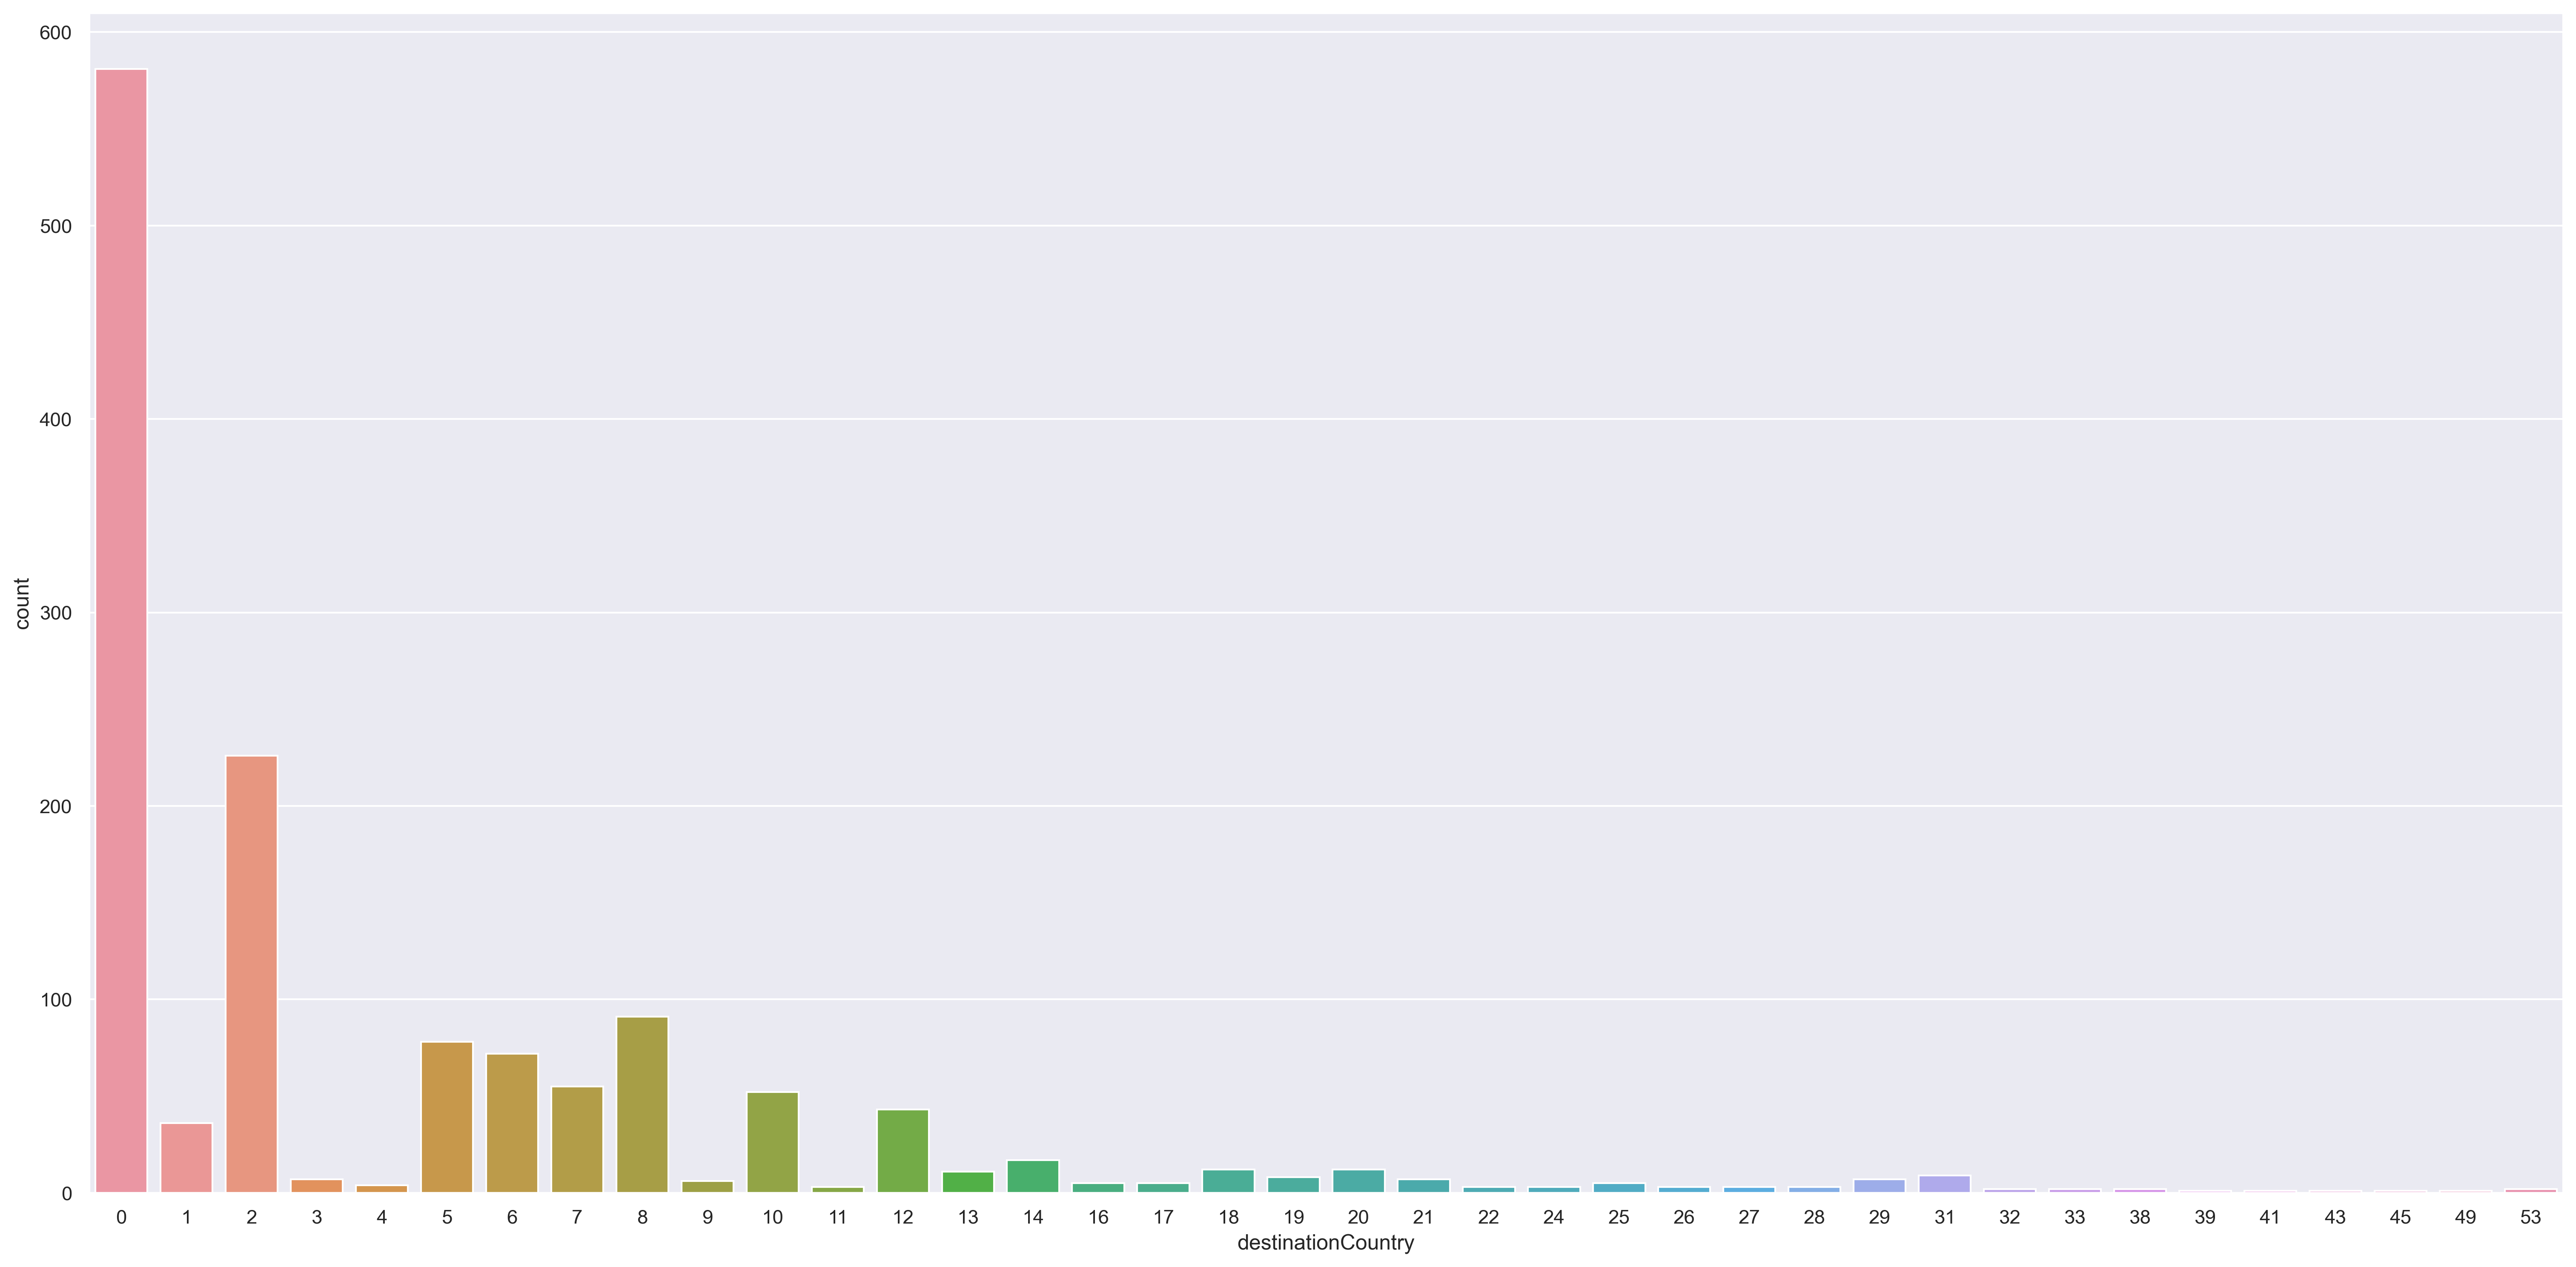

In [378]:
# Plot the number of destination countries for cancelled orders

plt.figure(figsize=(25,12), dpi=300)
p = sns.countplot(x="destinationCountry", data=cancelled_orders)
plt.show()

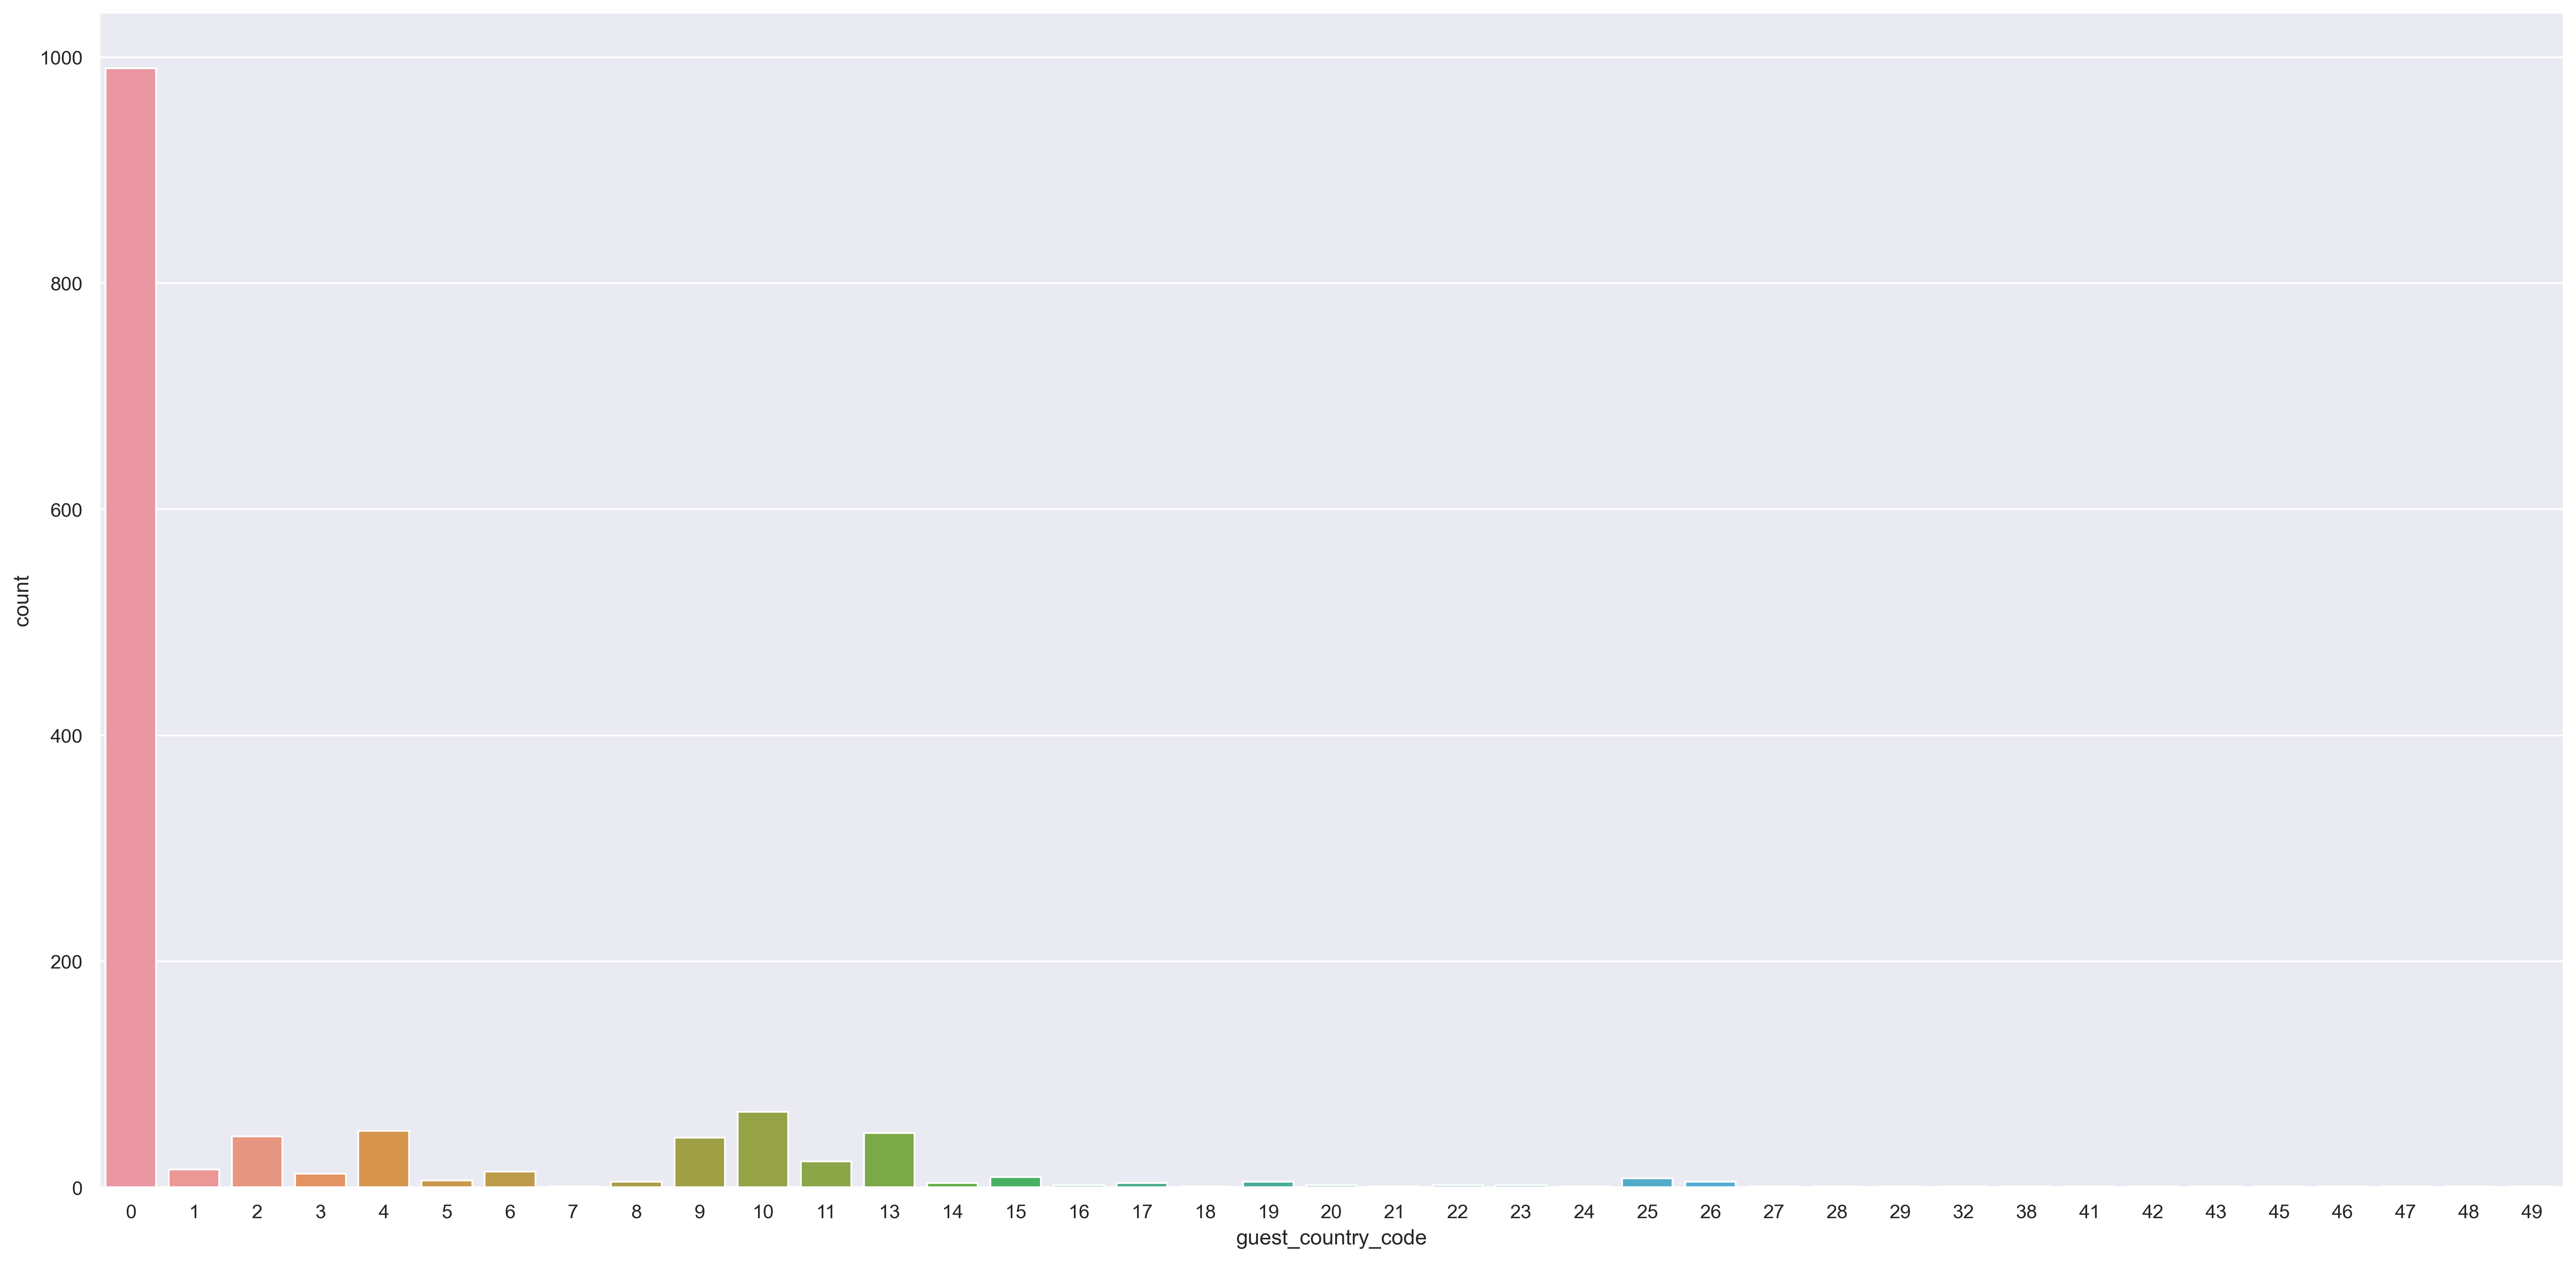

In [379]:
# Plot the number of destination countries for cancelled orders
plt.figure(figsize=(25,12), dpi=300)
p = sns.countplot(x="guest_country_code", data=cancelled_orders)
plt.show()

### ToDo: More EDA !

### Factorizing String values to numbers

In [380]:
df.columns

Index(['destinationCountry', 'roomCount', 'udid', 'email', 'phone',
       'guest_country_code', 'is_cardless', 'stars', 'type',
       'NormalizedTotalBookingPrice', 'NormalizedLowRate',
       'numberOfBookedNights', 'numberOfReviews', 'AvgUserRating', 'hotel_id',
       'hasSpecialRequest', 'hasFreeCancellation', 'cancelledOrNoShow',
       'is_internal'],
      dtype='object')

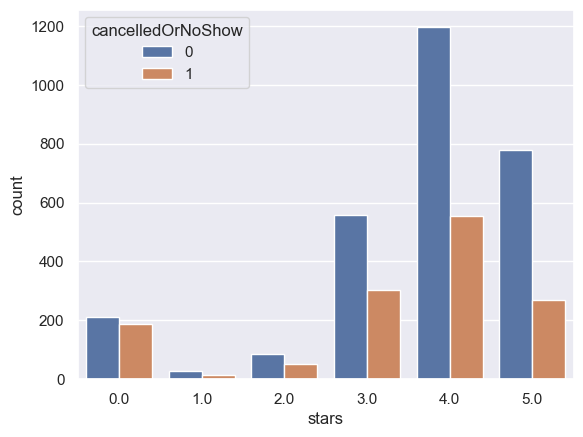

In [381]:
sns.countplot(x='stars', hue='cancelledOrNoShow', data=df)
plt.show()

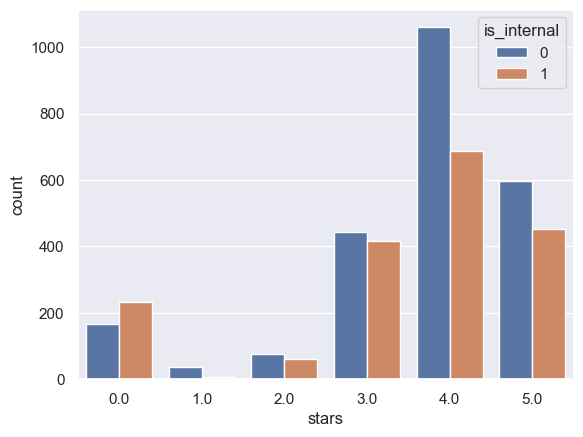

In [382]:
sns.countplot(x='stars', hue='is_internal', data=df)
plt.show()

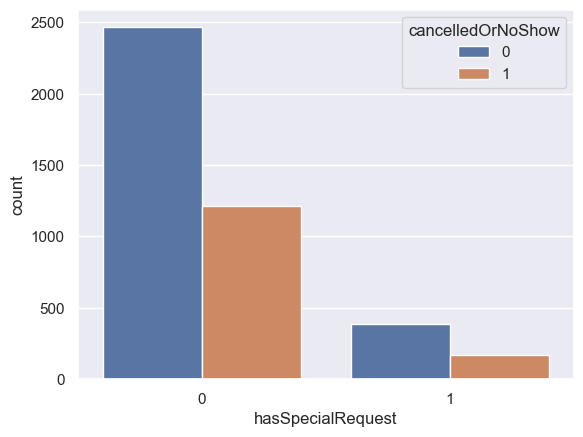

In [383]:
sns.countplot(x='hasSpecialRequest', hue='cancelledOrNoShow', data=df)
plt.show()

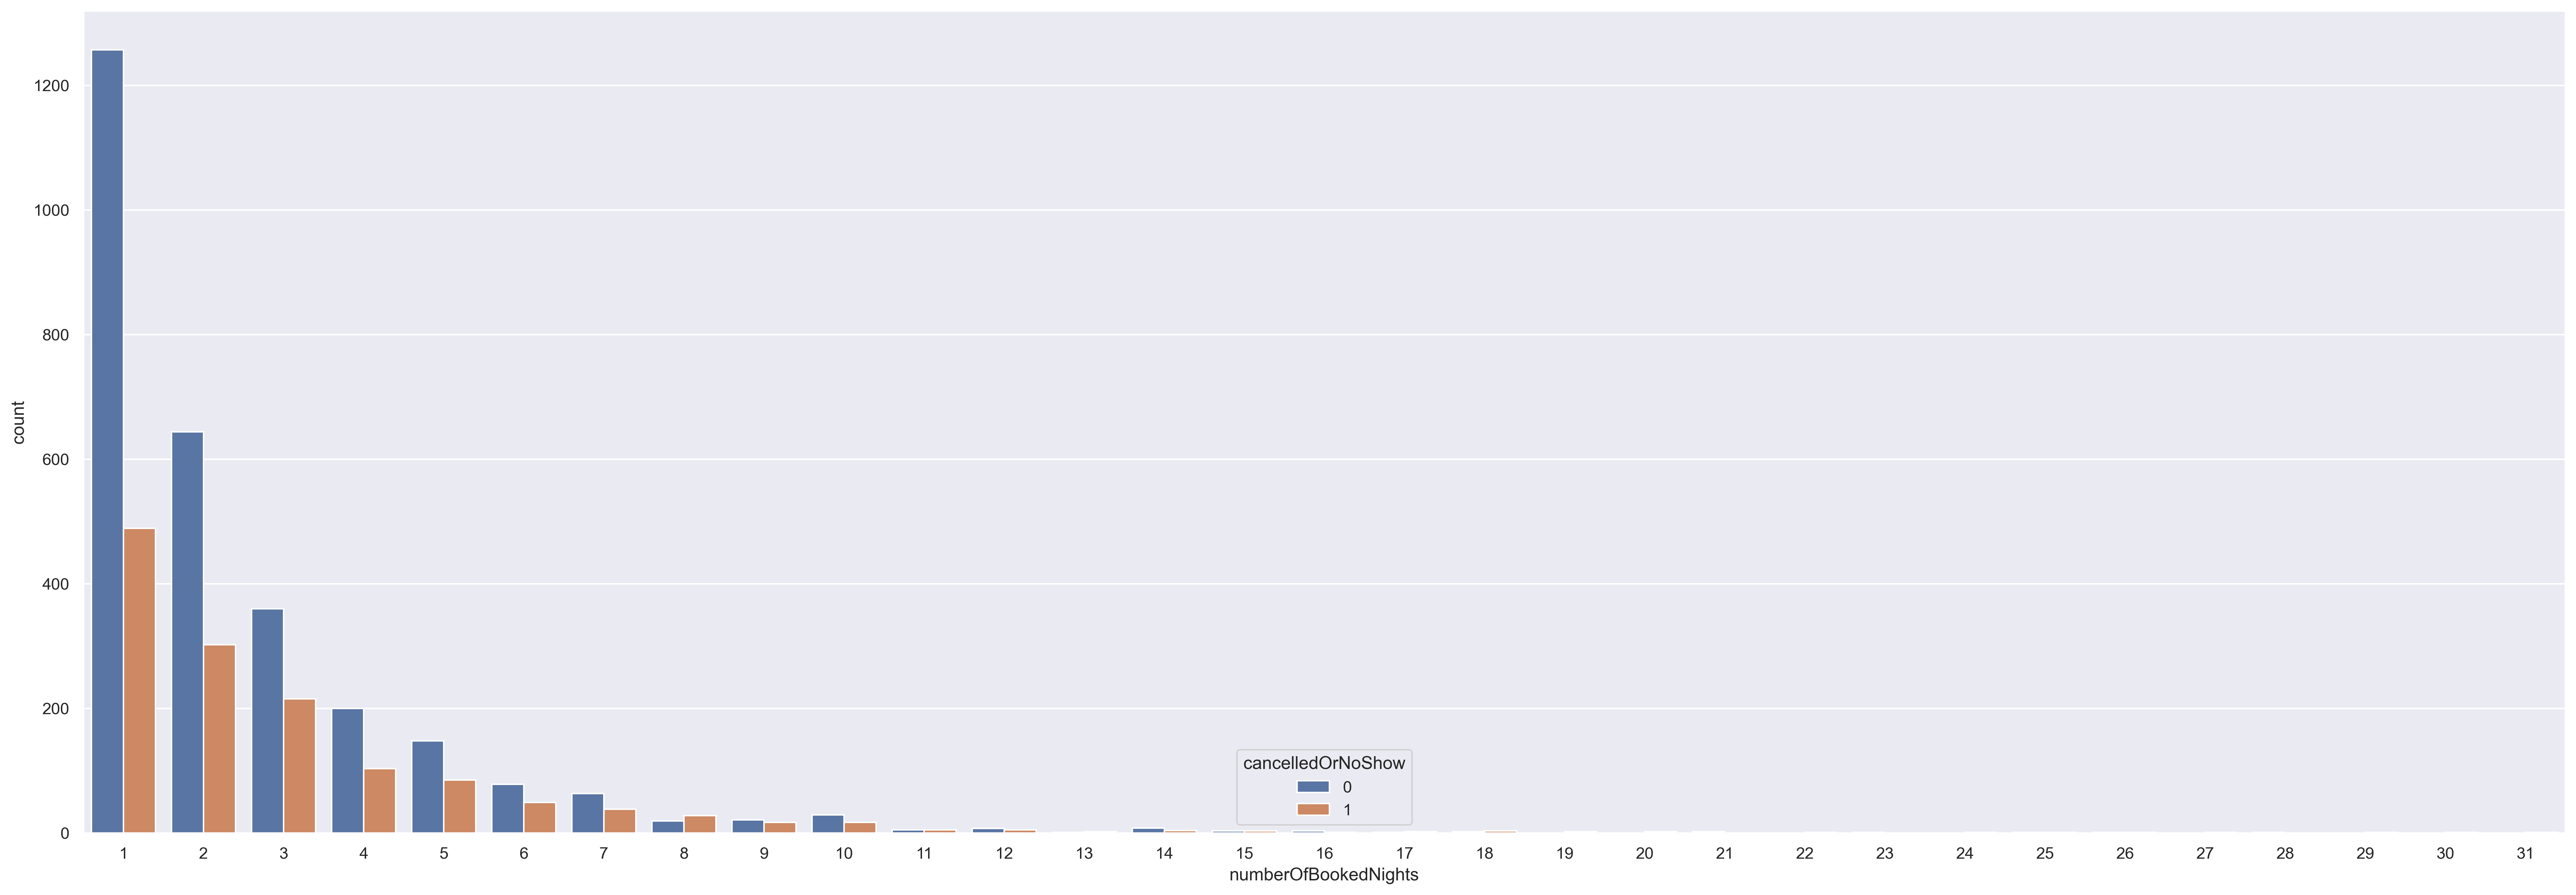

In [384]:
plt.figure(figsize=(30,10), dpi=300)
sns.countplot(x='numberOfBookedNights', hue= 'cancelledOrNoShow', data=df)
plt.show()

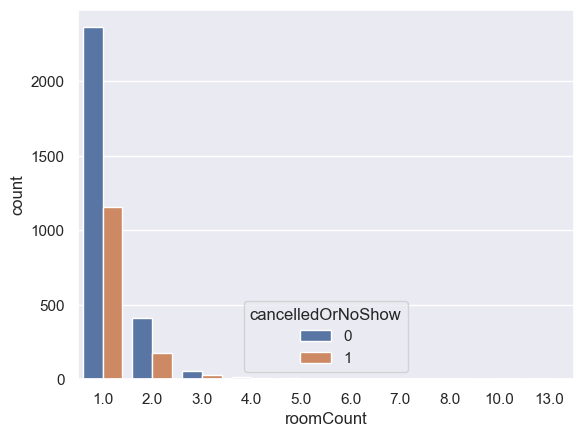

In [385]:
sns.countplot(x='roomCount', hue= 'cancelledOrNoShow', data=df)
plt.show()

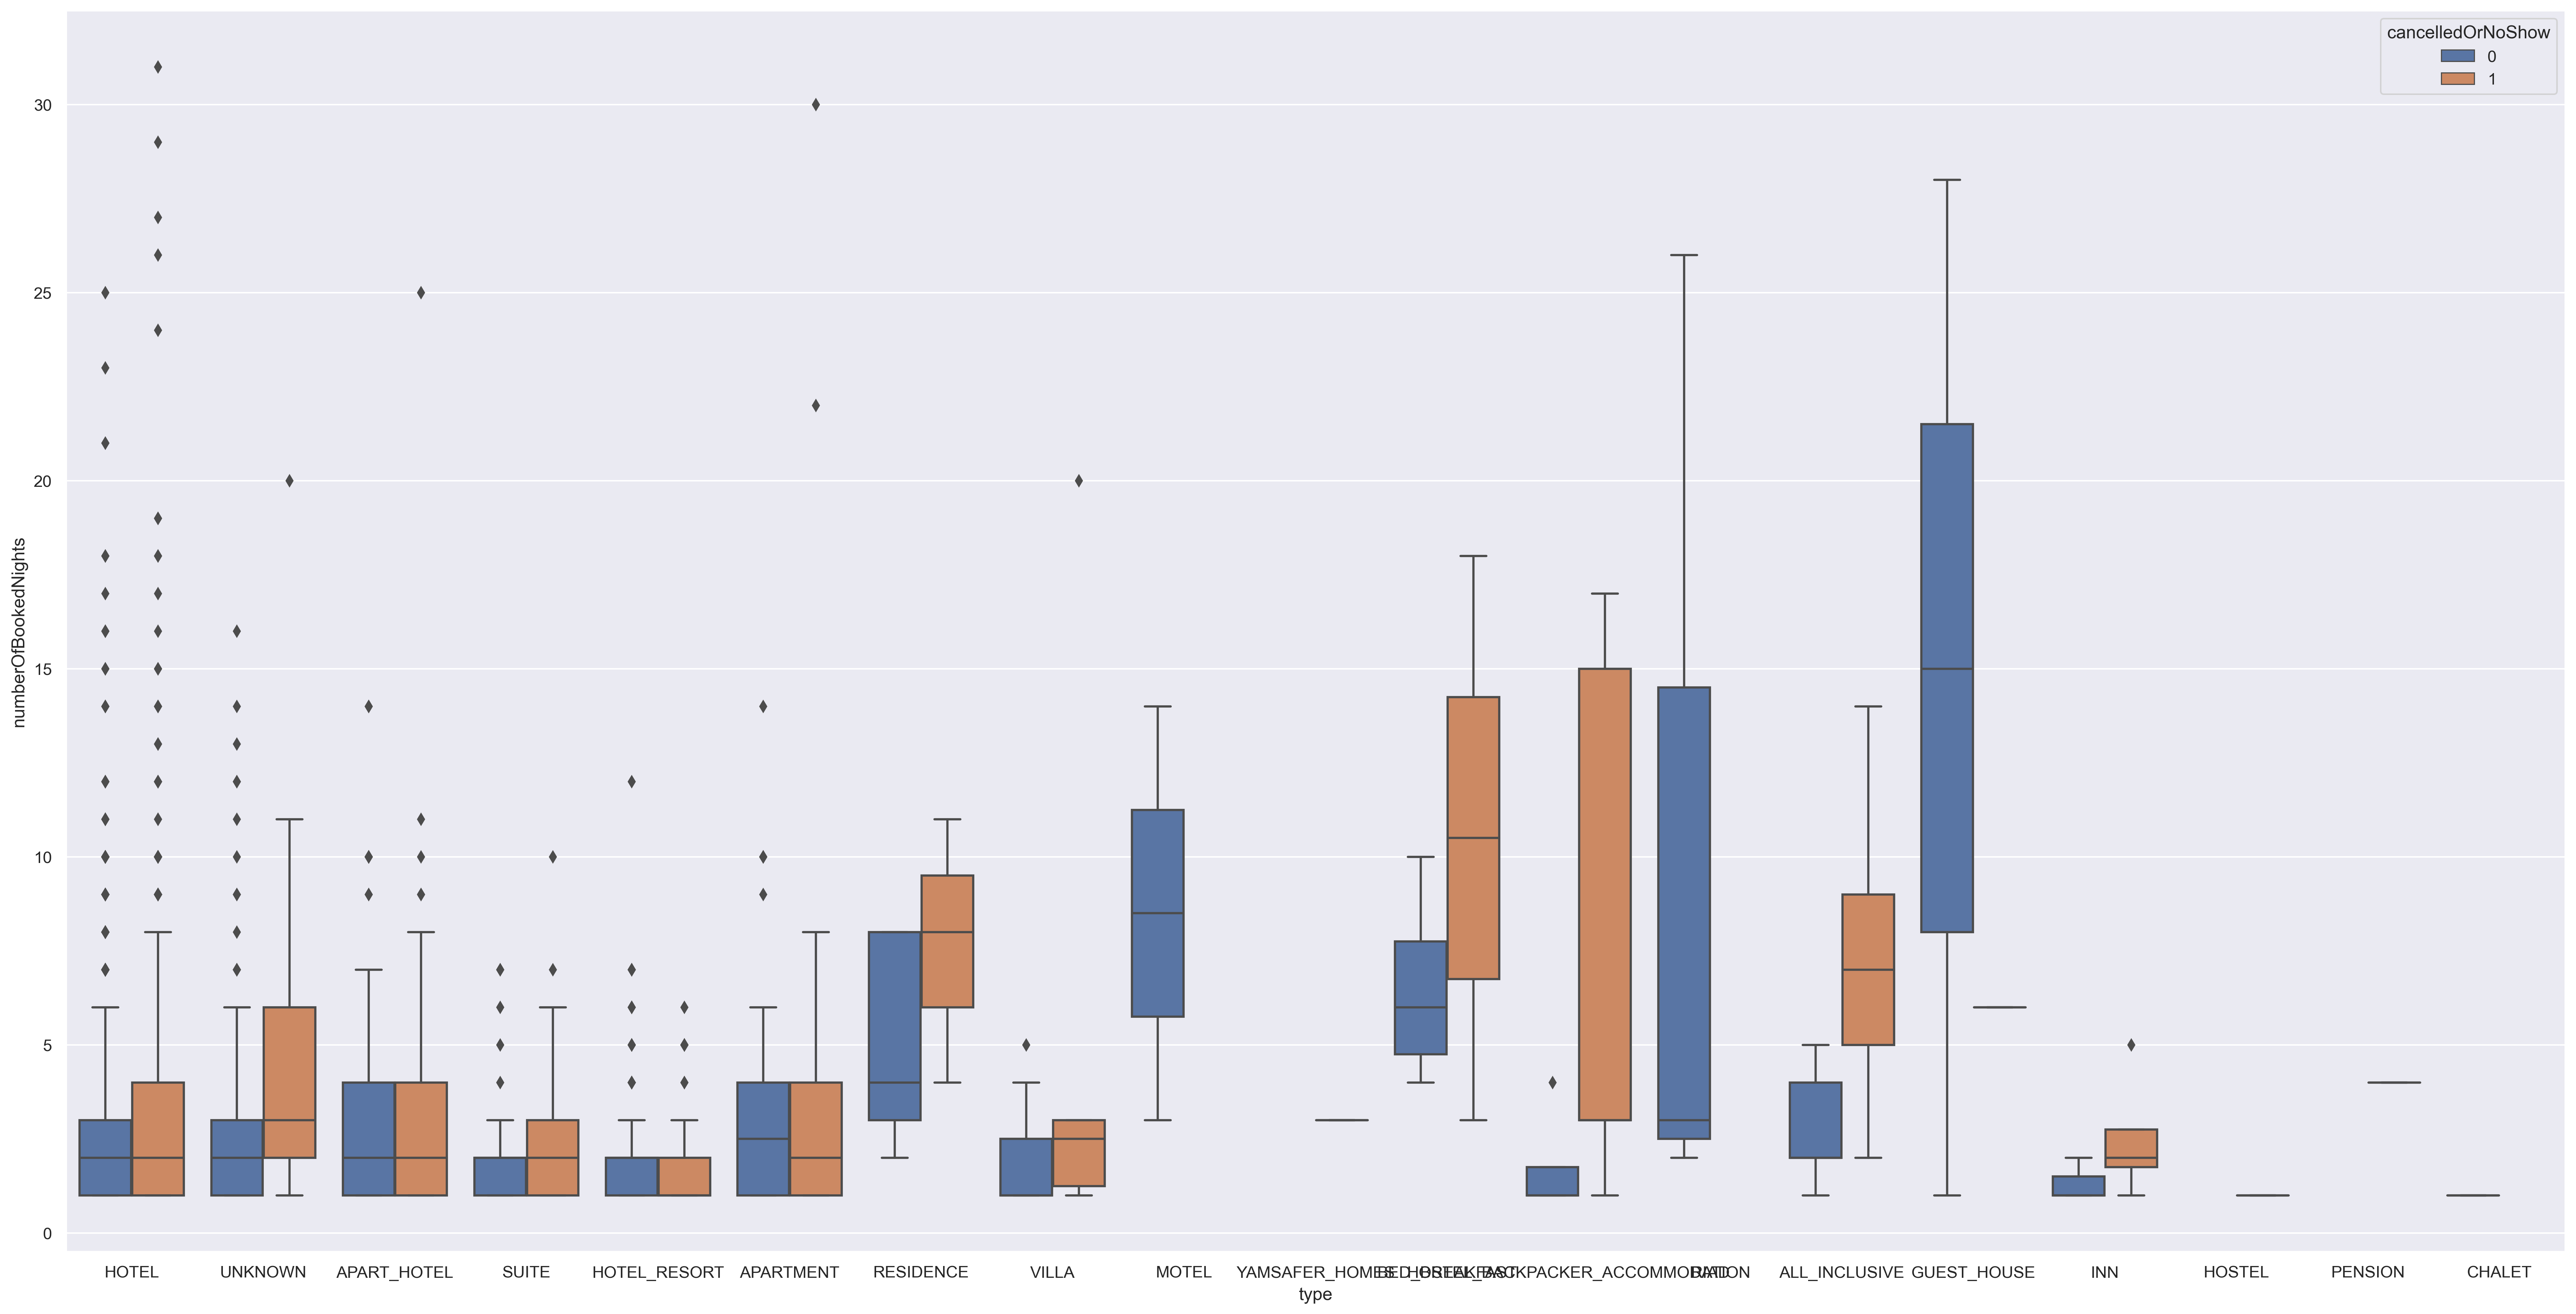

In [386]:
plt.figure(figsize=(30,15), dpi=300)
sns.boxplot(x='type', y='numberOfBookedNights', hue='cancelledOrNoShow', data=df)
plt.show()

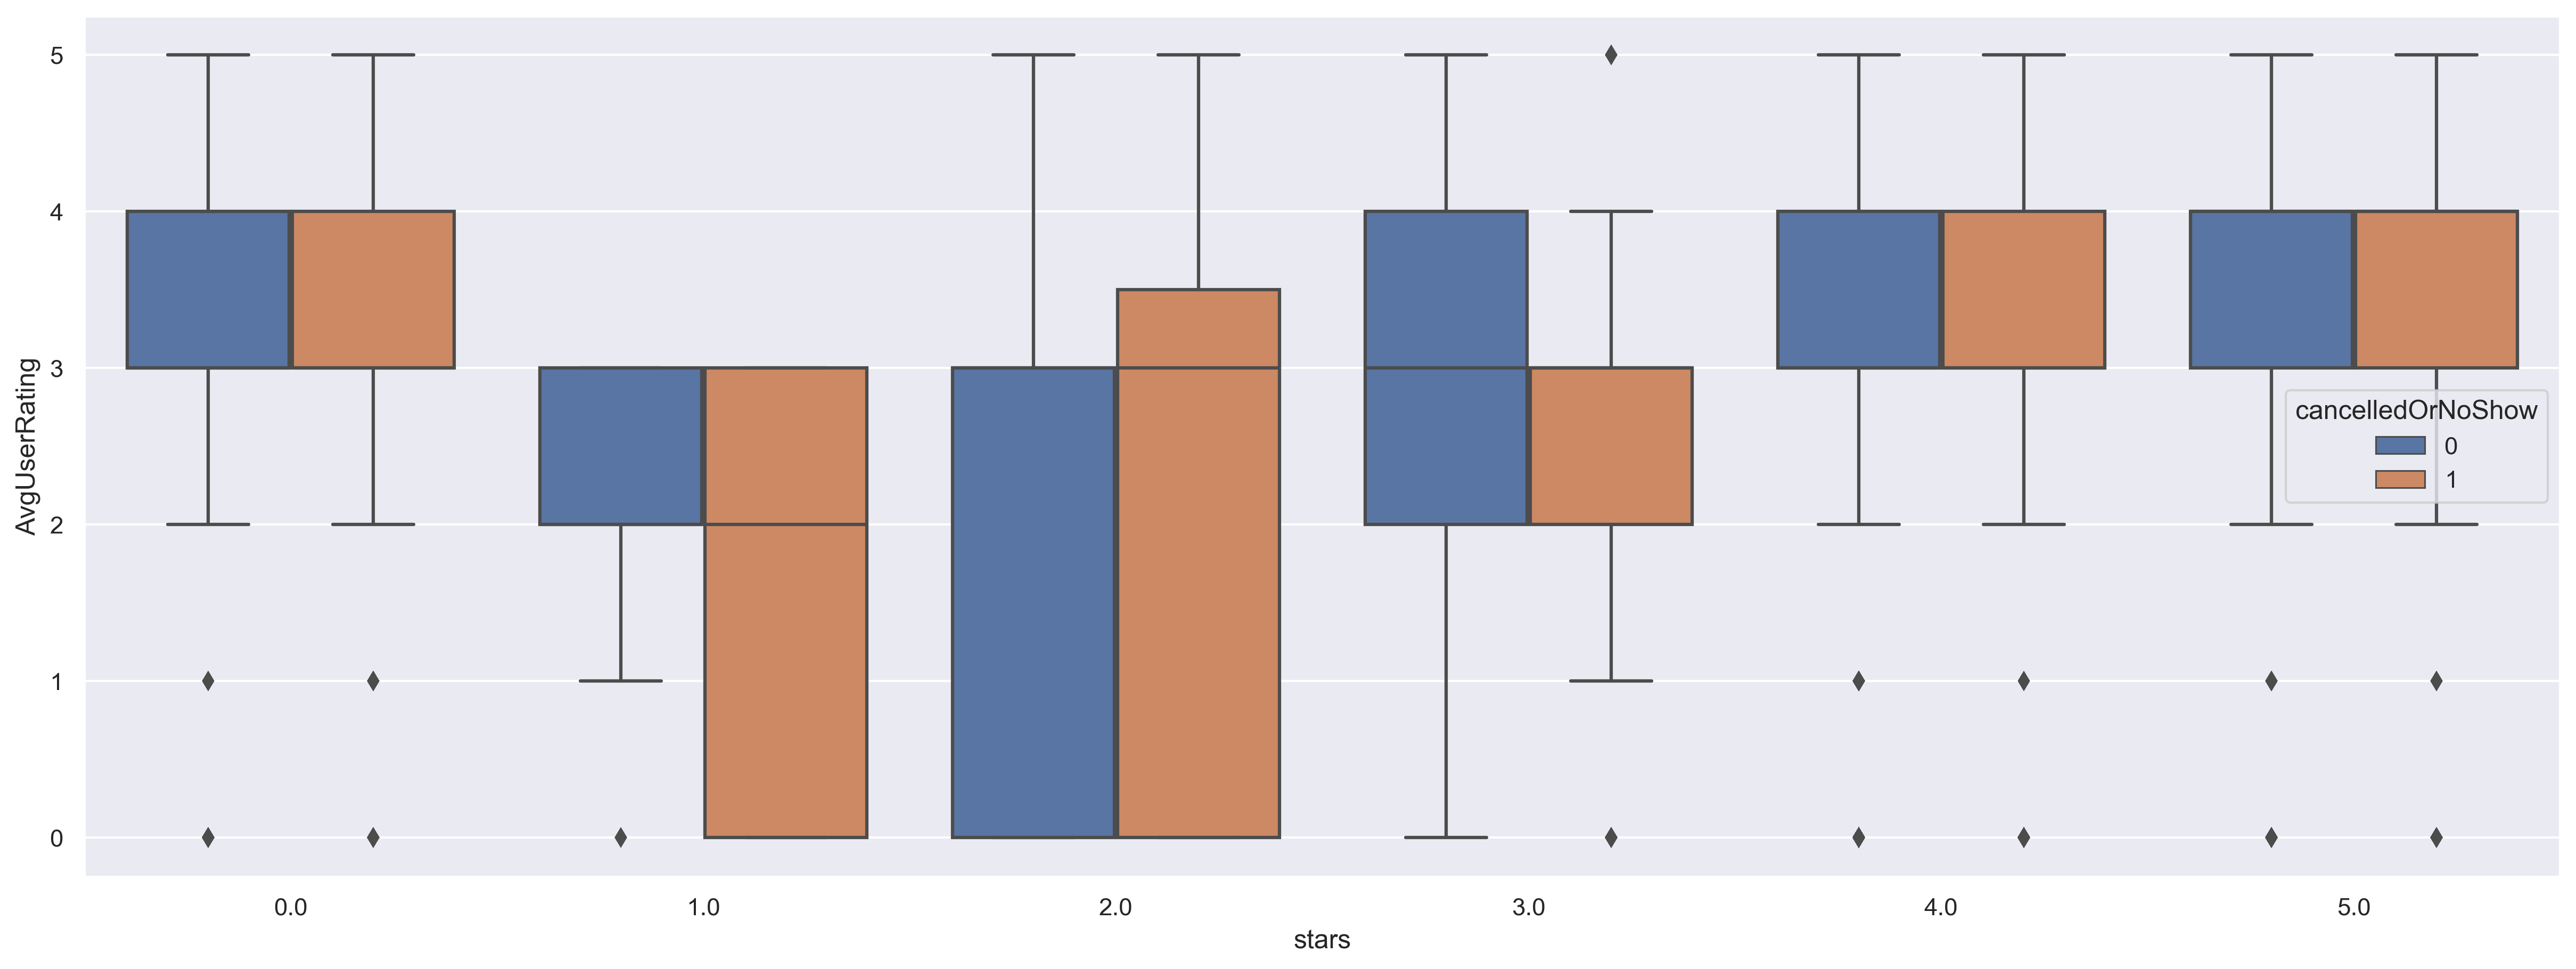

In [387]:
plt.figure(figsize=(20,7), dpi=300)
sns.boxplot(x='stars', y='AvgUserRating', hue= 'cancelledOrNoShow', data=df)
plt.show()

#### We see that users tend to cancel more based on bad reviews from previous guests

## Looks like unrated hotels are mostly 4 star hotels

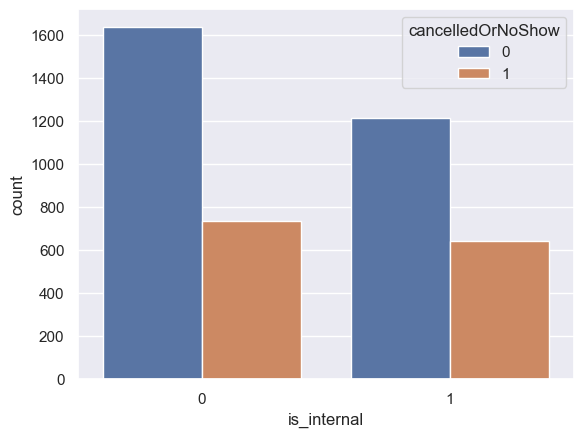

In [388]:
sns.countplot(x='is_internal', hue='cancelledOrNoShow', data=df)
plt.show()

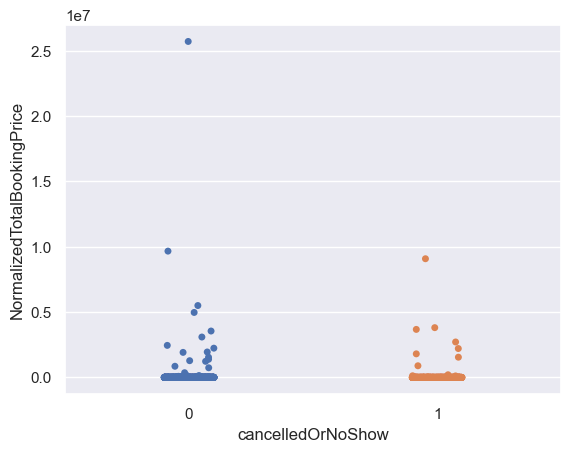

In [389]:
sns.stripplot(x="cancelledOrNoShow", y="NormalizedTotalBookingPrice", data=df);

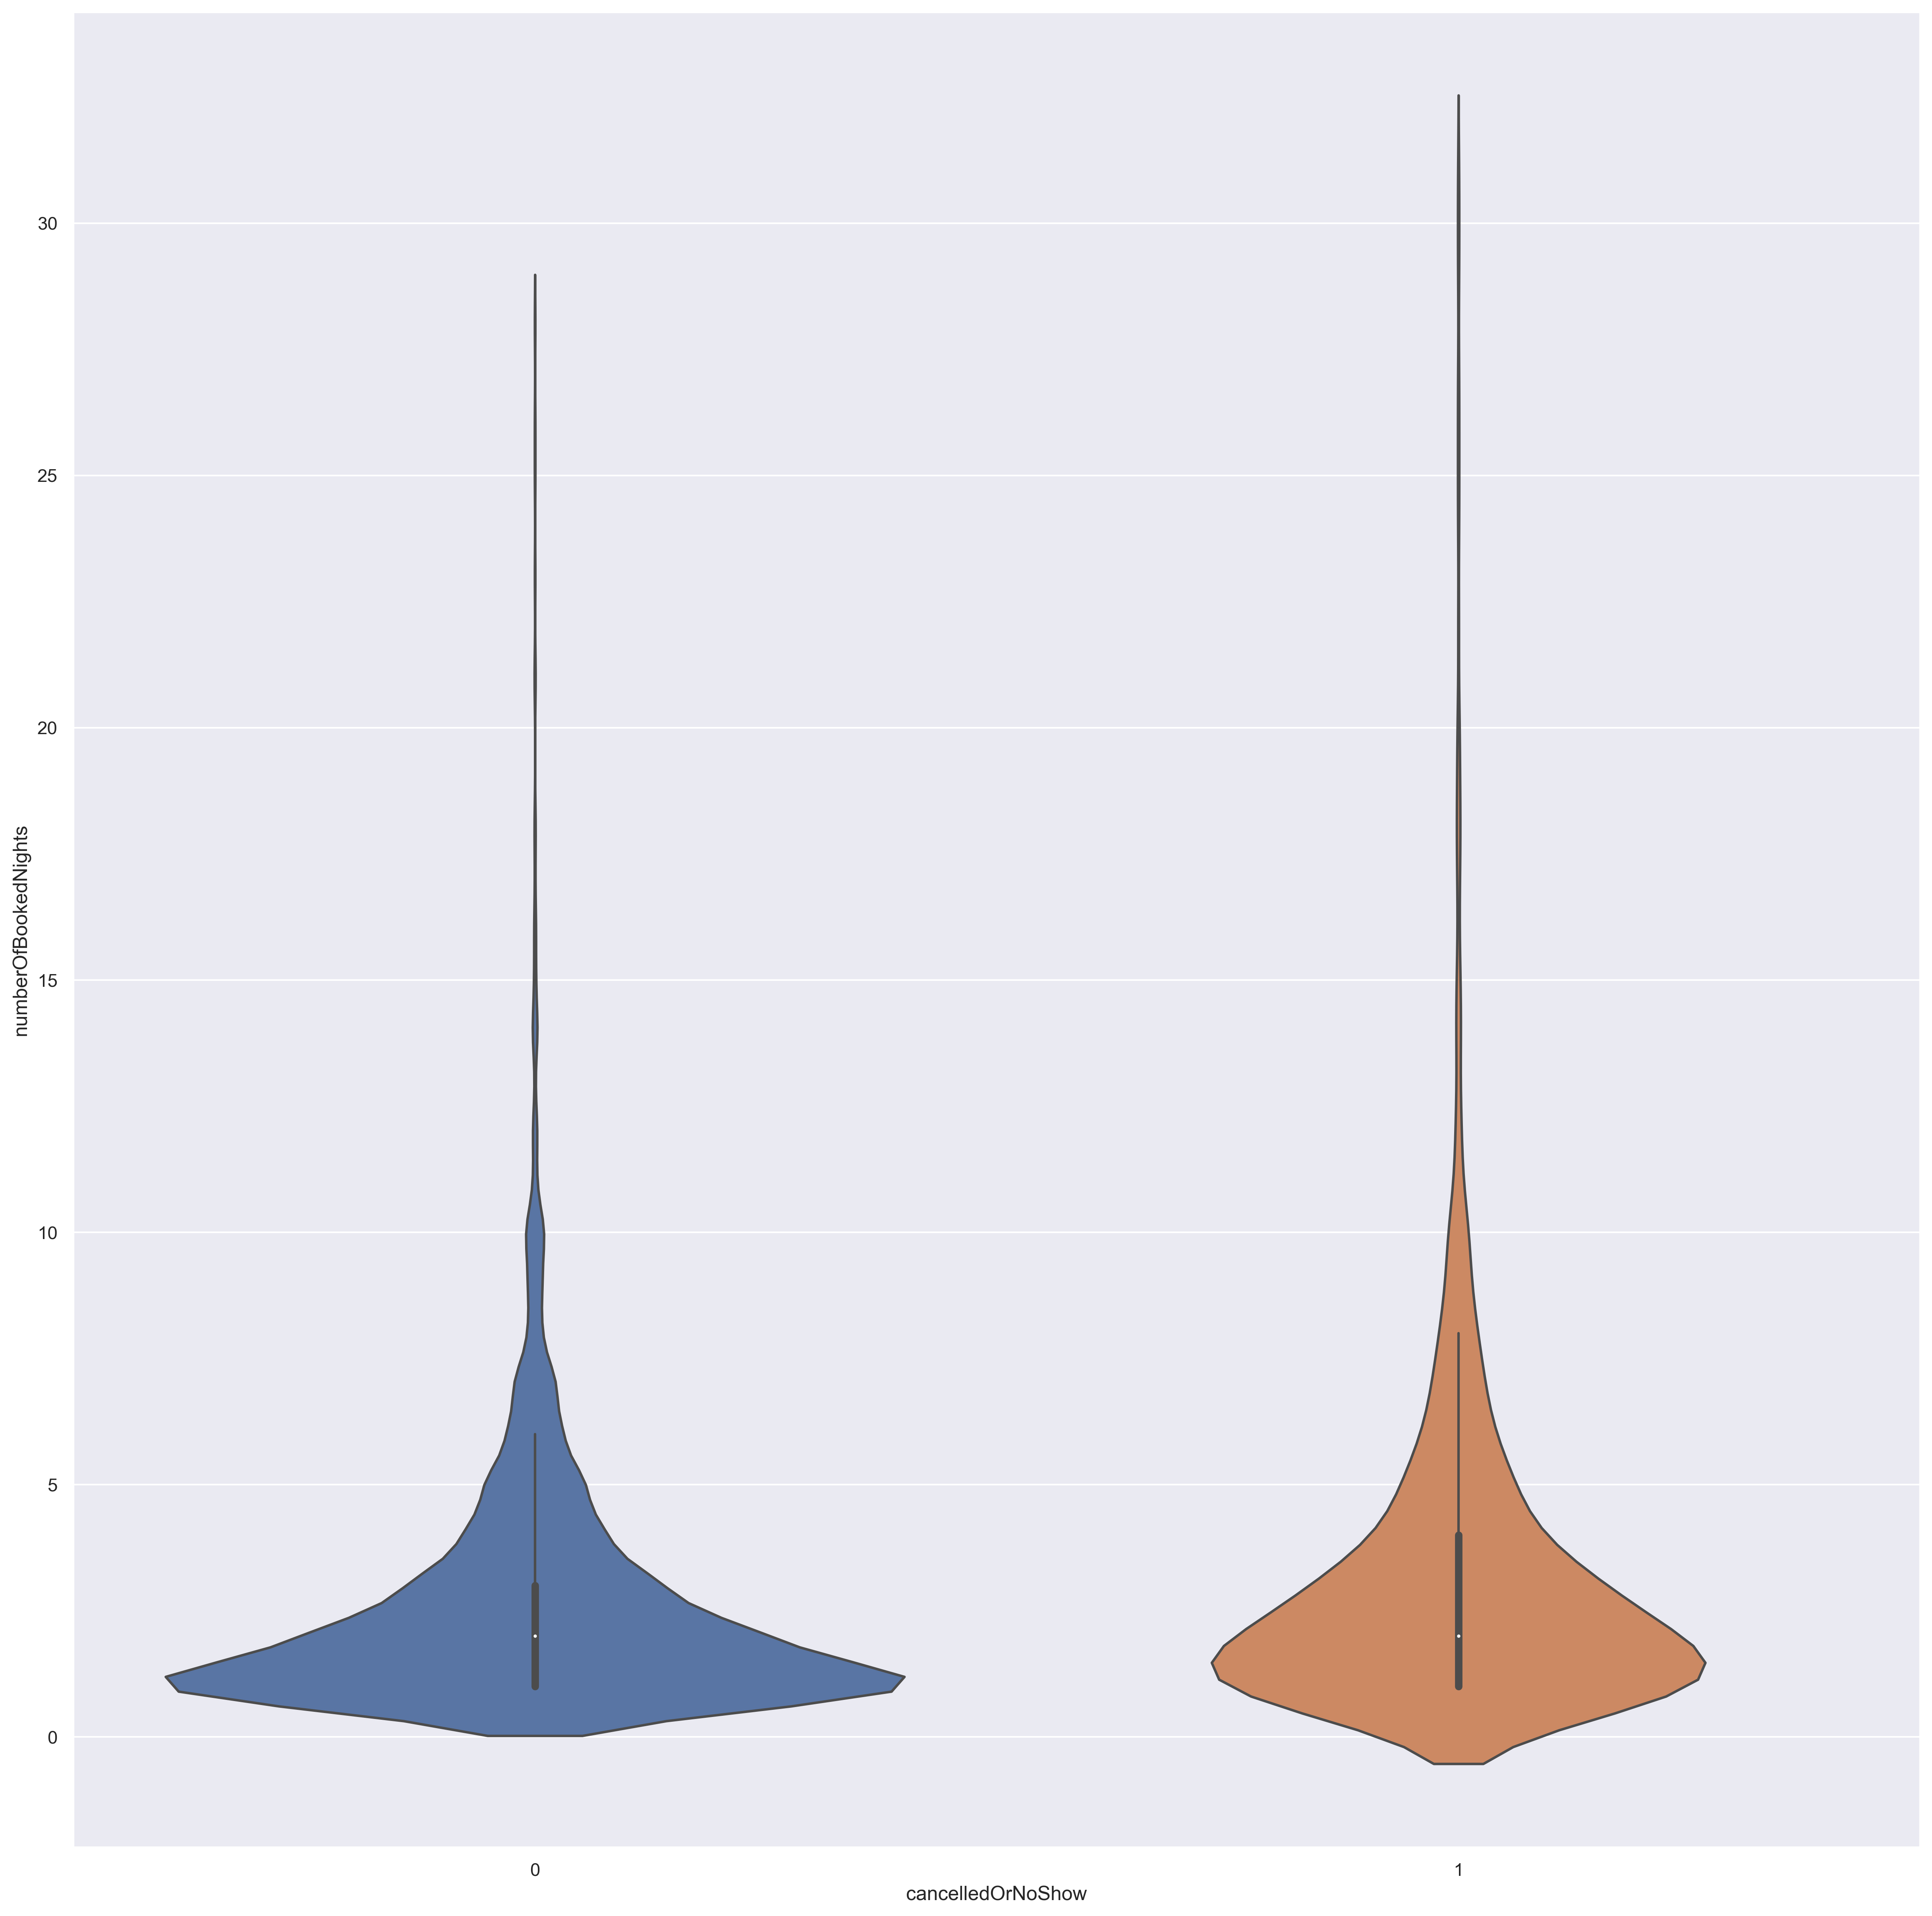

In [390]:
plt.figure(figsize=(20,20), dpi=300)
sns.violinplot(x="cancelledOrNoShow", y="numberOfBookedNights", data=df, split=True);

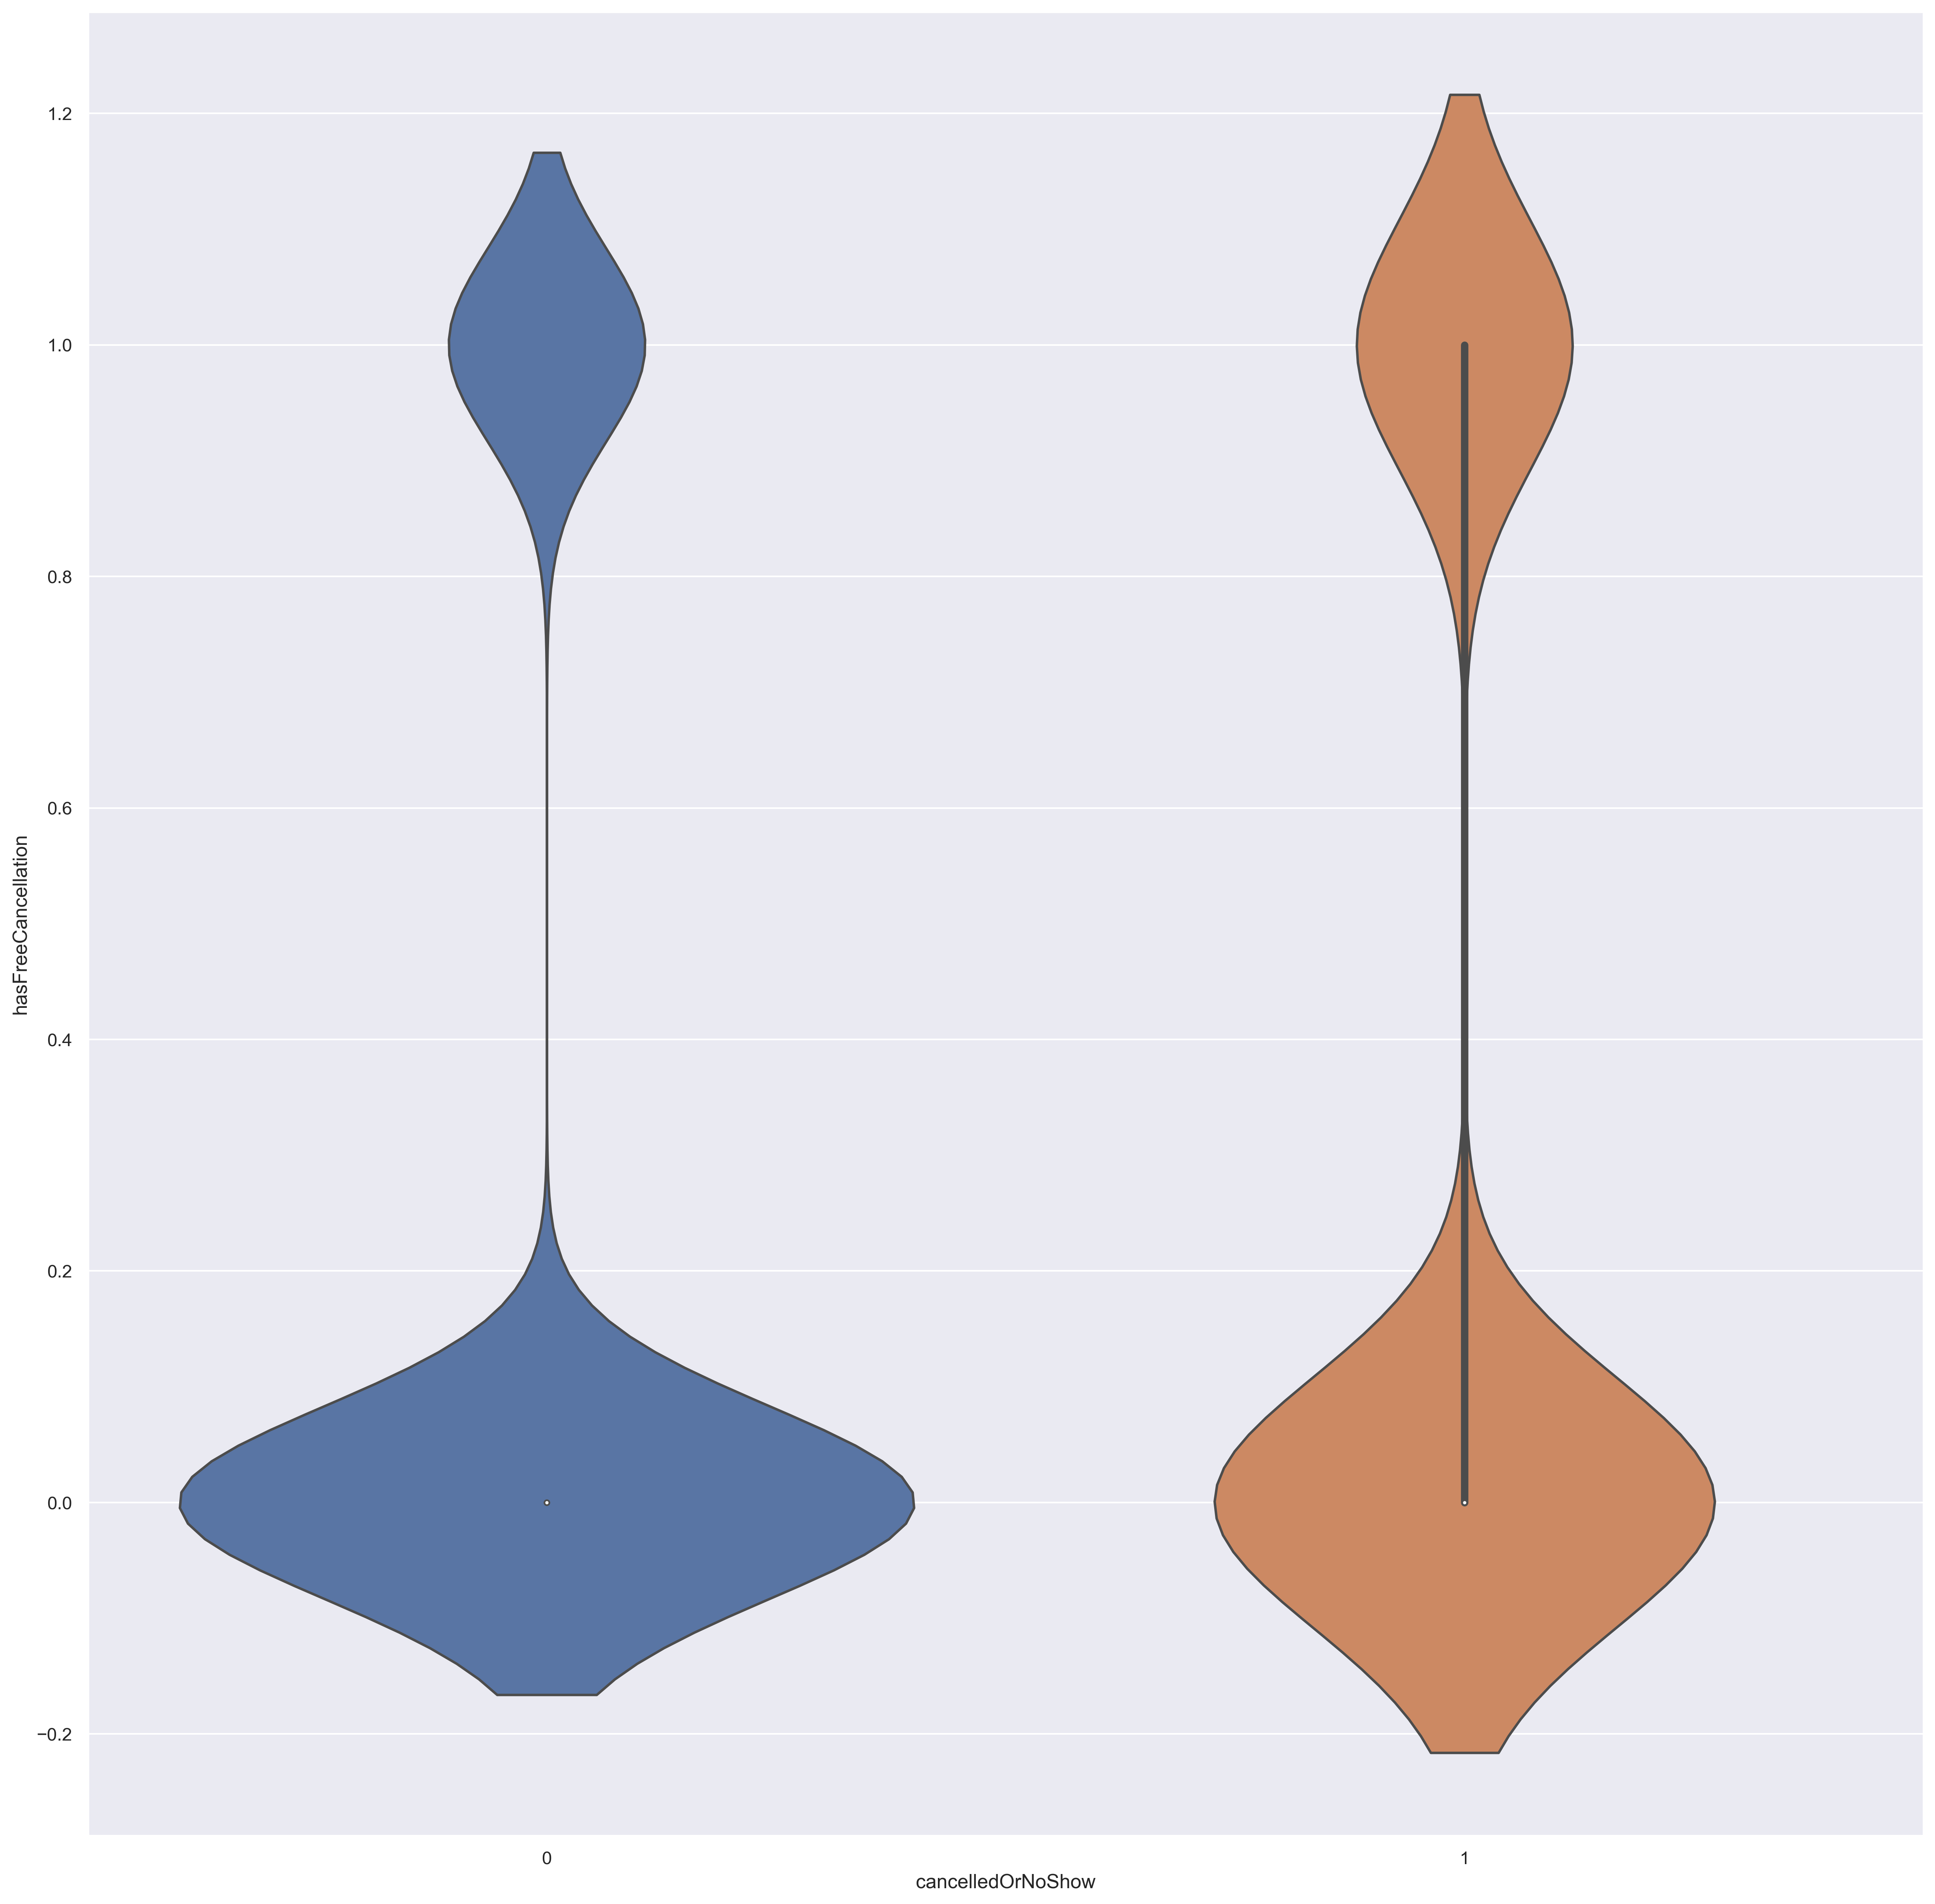

In [391]:
plt.figure(figsize=(20,20), dpi=300)
#axis(side=1,at=1:19)
sns.violinplot(x="cancelledOrNoShow", y="hasFreeCancellation", data=df, split=True);

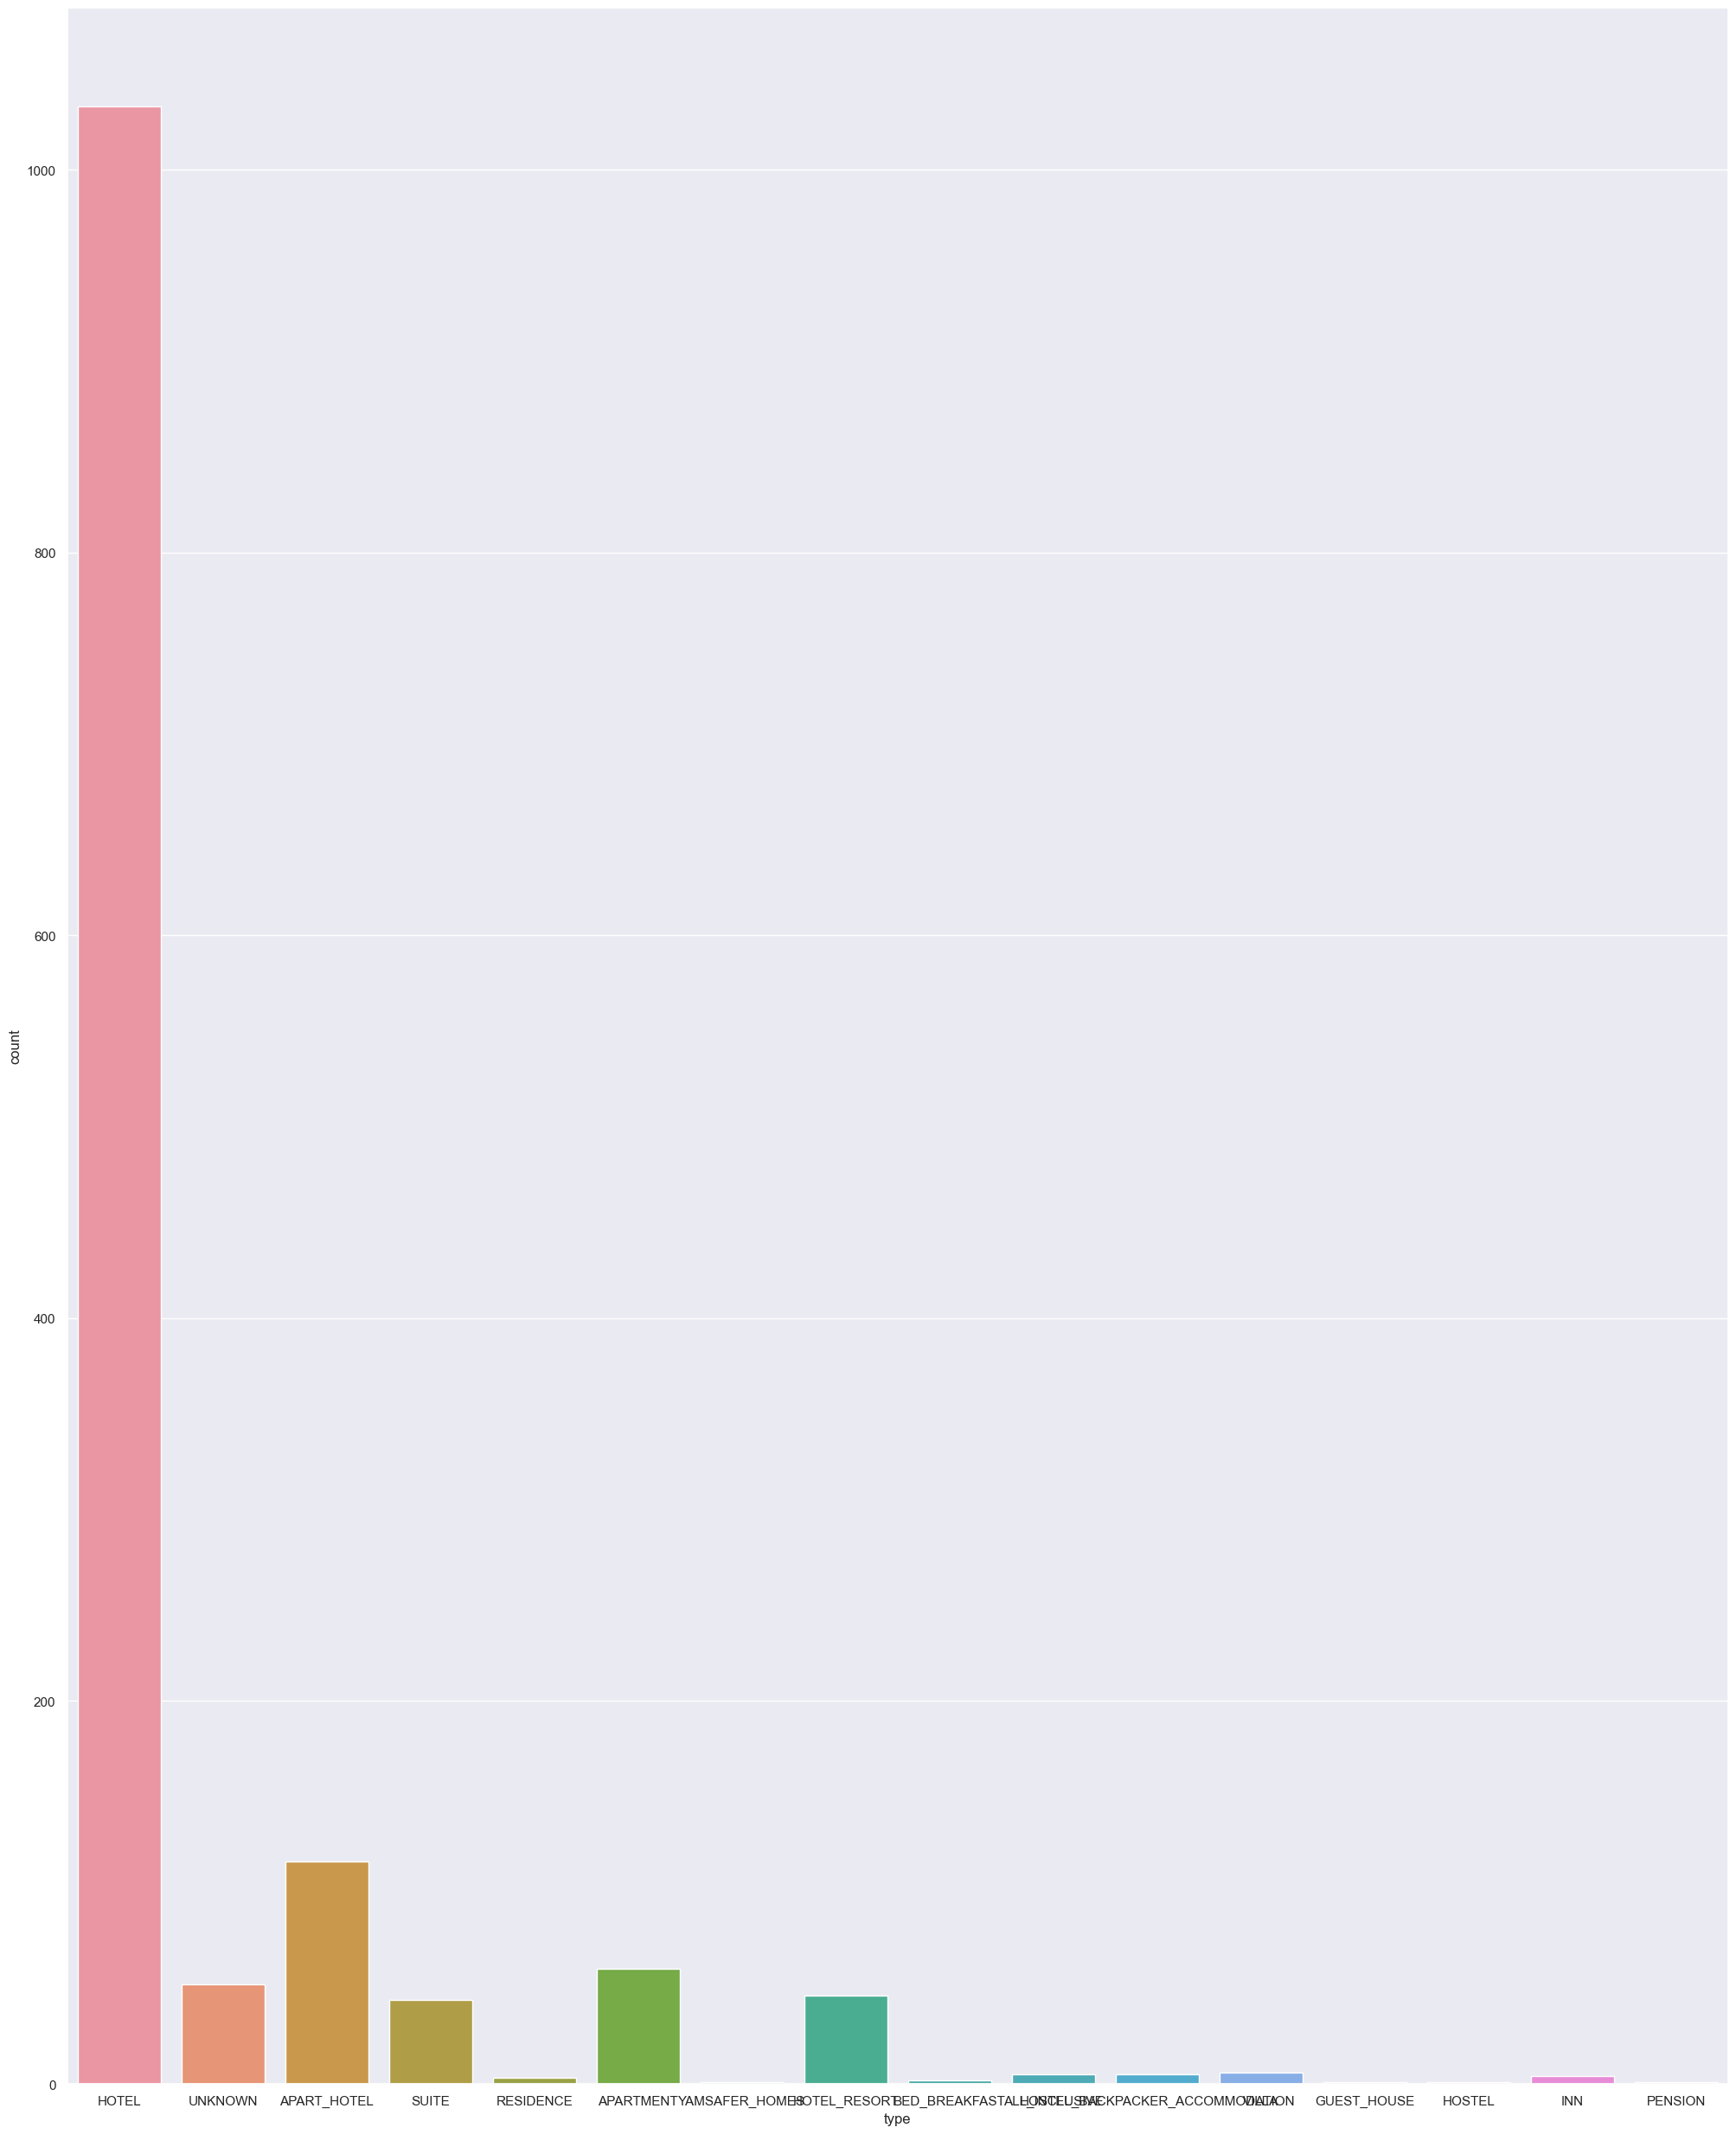

In [392]:
sns.set()
ax2 = plt.axes([0, 2, 3, 5])
sns.countplot(x='type', data=cancelled_orders)
plt.show()

## Factorize by Property Type

In [393]:
labels, levels = pd.factorize(df['type'])
df['type']= labels

#labels, levels = pd.factorize(df_feat['type'])
#df_feat['type']= labels

## Finding Correlations

/var/folders/4z/d9jzxpr10qqgqtggyppxfzpc0000gn/T/ipykernel_24402/2540598199.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),


<AxesSubplot:>

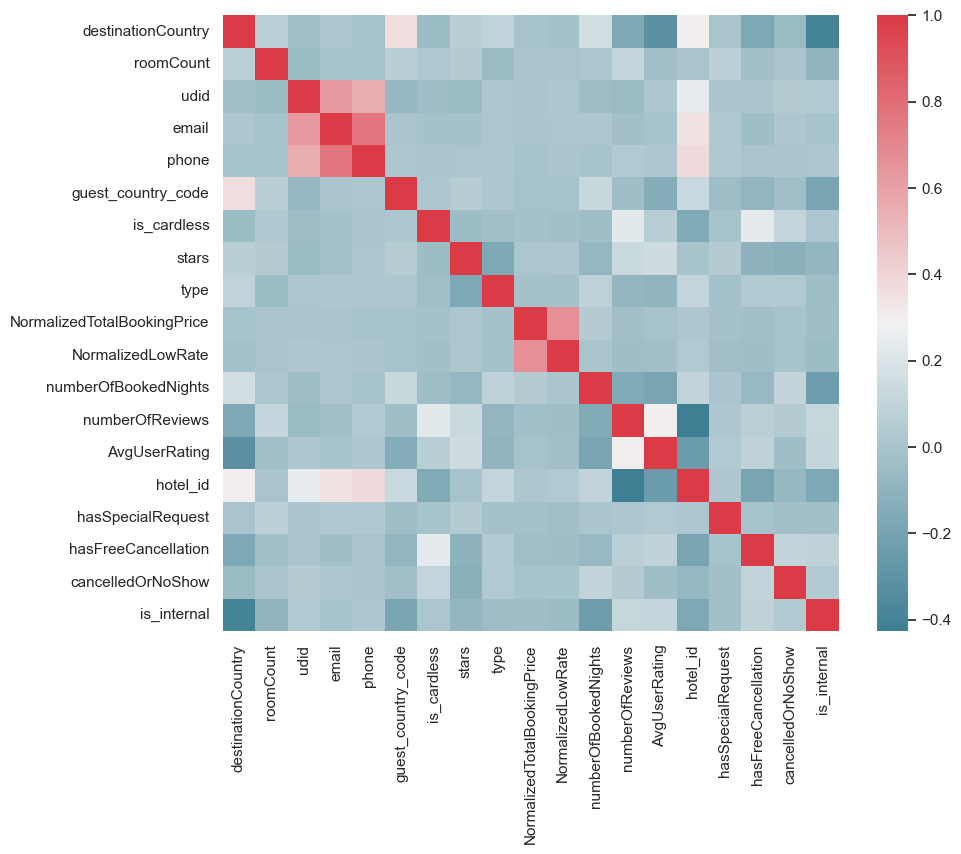

In [394]:
import seaborn as sns
sns.set()
import seaborn as sns
f, ax = plt.subplots(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [395]:
df.columns

Index(['destinationCountry', 'roomCount', 'udid', 'email', 'phone',
       'guest_country_code', 'is_cardless', 'stars', 'type',
       'NormalizedTotalBookingPrice', 'NormalizedLowRate',
       'numberOfBookedNights', 'numberOfReviews', 'AvgUserRating', 'hotel_id',
       'hasSpecialRequest', 'hasFreeCancellation', 'cancelledOrNoShow',
       'is_internal'],
      dtype='object')

## Create features and targets

In [396]:
df_target        = df['cancelledOrNoShow']
df_feat_all      = df.drop(['cancelledOrNoShow'], axis=1)
df_feat_selected = df[['is_cardless', 'numberOfBookedNights', 'hasFreeCancellation', 'hasSpecialRequest']]

# Machine Learning:

### Definig Features and Targets

In [397]:
df_target = df['cancelledOrNoShow']
#Setting the features
df_feat_all      = df.drop(['cancelledOrNoShow'], axis=1)
df_feat_selected = df[['is_cardless', 'numberOfBookedNights', 'hasFreeCancellation', 'hasSpecialRequest']]

In [398]:
df_feat_all.head()

,destinationCountry,roomCount,udid,email,phone,guest_country_code,is_cardless,stars,type,NormalizedTotalBookingPrice,NormalizedLowRate,numberOfBookedNights,numberOfReviews,AvgUserRating,hotel_id,hasSpecialRequest,hasFreeCancellation,is_internal
0,0,1.0,0,0,0,0,0,4.0,0,229.0,166.0,1,103.0,4.0,0,0,1,1
1,1,2.0,1,1,1,0,0,1.0,0,126.0,90.0,2,10.0,1.0,1,0,0,0
2,2,1.0,2,2,2,0,0,5.0,0,1722.0,753.0,4,25.0,4.0,2,1,0,0
3,0,1.0,3,3,3,1,0,4.0,1,685.0,373.0,2,16.0,4.0,3,0,0,0
4,2,1.0,0,4,4,2,0,5.0,0,427.0,401.0,1,10.0,5.0,4,0,0,1


# Decision Trees

In [399]:
df.columns

Index(['destinationCountry', 'roomCount', 'udid', 'email', 'phone',
       'guest_country_code', 'is_cardless', 'stars', 'type',
       'NormalizedTotalBookingPrice', 'NormalizedLowRate',
       'numberOfBookedNights', 'numberOfReviews', 'AvgUserRating', 'hotel_id',
       'hasSpecialRequest', 'hasFreeCancellation', 'cancelledOrNoShow',
       'is_internal'],
      dtype='object')

In [400]:
new_df = df[['roomCount', 'destinationCountry', 'guest_country_code', 'stars', 'NormalizedTotalBookingPrice', 'cancelledOrNoShow']]

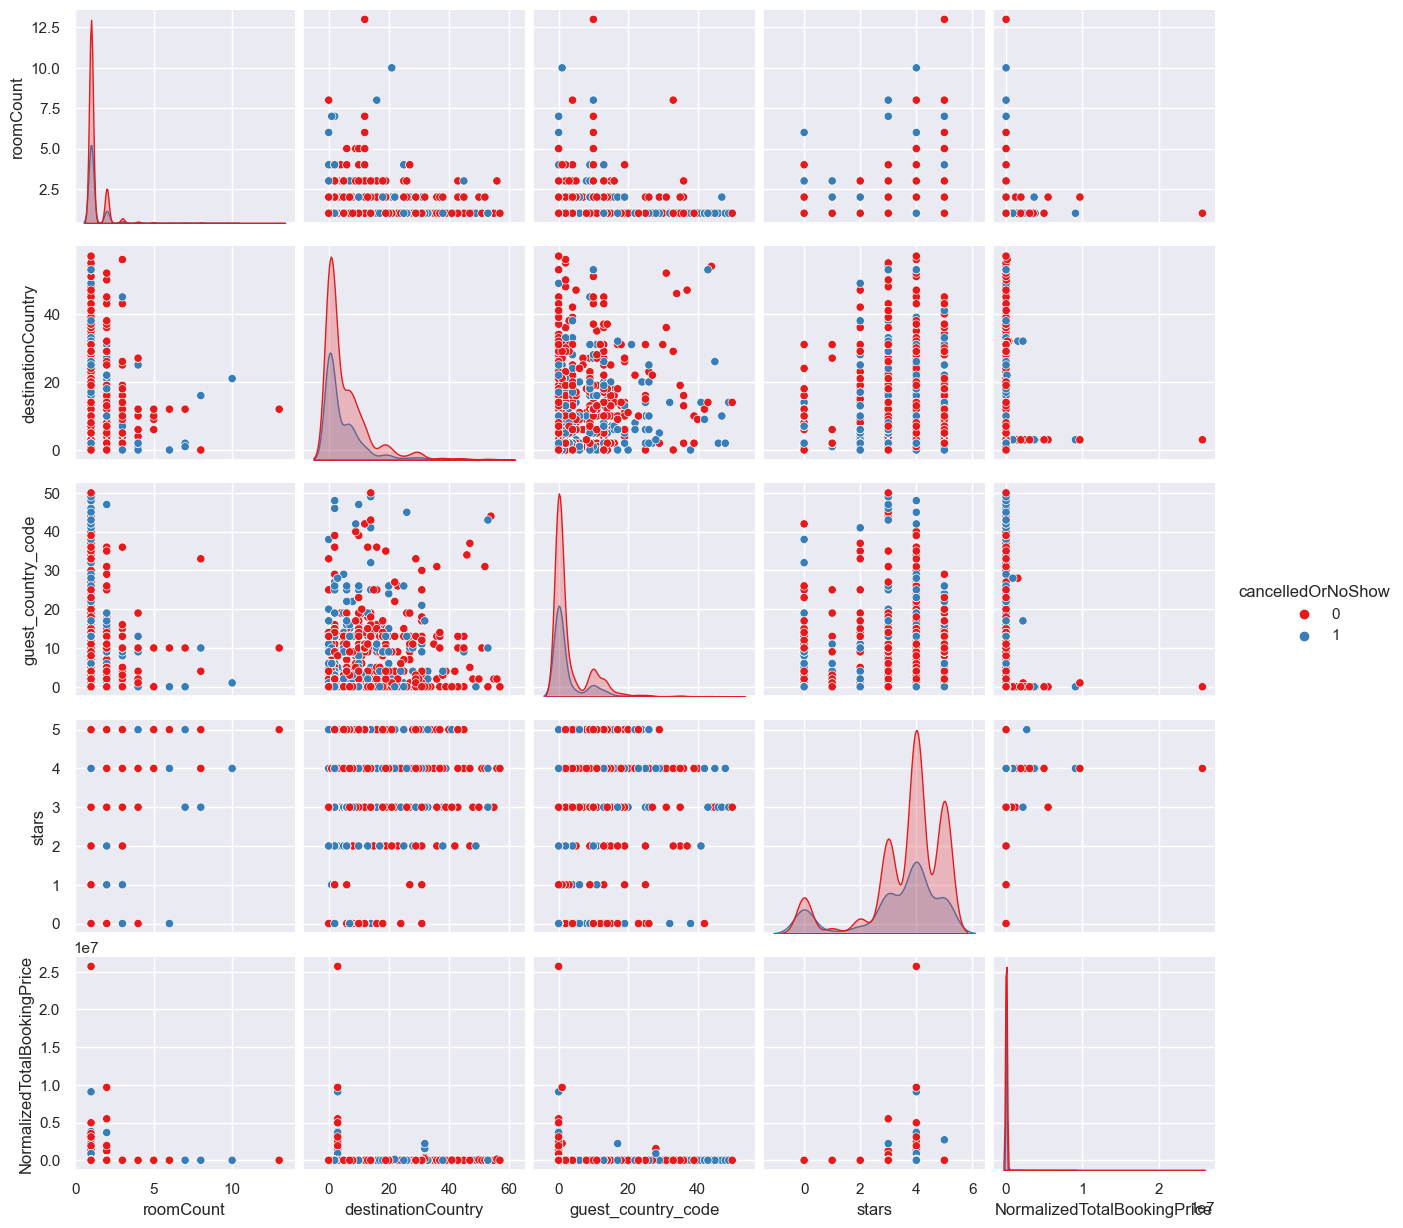

In [401]:
sns.pairplot(new_df,hue='cancelledOrNoShow',palette='Set1')

### Train Test Split

In [402]:
from sklearn.model_selection import train_test_split

In [403]:
X_train, X_test, y_train, y_test = train_test_split(df_feat_all, np.ravel(df_target), test_size=0.30, random_state=101)

In [404]:
from sklearn.tree import DecisionTreeClassifier

In [405]:
dtree = DecisionTreeClassifier()

In [406]:
dtree.fit(X_train,y_train)

DecisionTreeClassifier()

### Prediction and Evaluation

In [407]:
predictions = dtree.predict(X_test)

In [408]:
from sklearn.metrics import classification_report,confusion_matrix

In [409]:
print(confusion_matrix(y_test,predictions))

[[595 268]
 [247 161]]


In [410]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.71      0.69      0.70       863
           1       0.38      0.39      0.38       408

    accuracy                           0.59      1271
   macro avg       0.54      0.54      0.54      1271
weighted avg       0.60      0.59      0.60      1271



## Try with selected features

In [411]:
df_feat_selected = df[['is_cardless', 'hasFreeCancellation', 'hasSpecialRequest', 'destinationCountry', 'stars', 'type']]

In [412]:
X_train, X_test, y_train, y_test = train_test_split(df_feat_selected, np.ravel(df_target), test_size=0.30, random_state=101)

In [413]:
dtree.fit(X_train,y_train)

DecisionTreeClassifier()

In [414]:
predictions = dtree.predict(X_test)

In [415]:
print(confusion_matrix(y_test,predictions))

[[746 117]
 [315  93]]


In [416]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.70      0.86      0.78       863
           1       0.44      0.23      0.30       408

    accuracy                           0.66      1271
   macro avg       0.57      0.55      0.54      1271
weighted avg       0.62      0.66      0.62      1271



# Random Forests

In [417]:
X_train, X_test, y_train, y_test = train_test_split(df_feat_all, np.ravel(df_target), test_size=0.30, random_state=101)

In [418]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=4)
rfc.fit(X_train, y_train)

RandomForestClassifier(n_estimators=4)

In [419]:
rfc_pred = rfc.predict(X_test)

In [420]:
print(confusion_matrix(y_test,rfc_pred))

[[741 122]
 [294 114]]


In [421]:
print(classification_report(y_test,rfc_pred))

              precision    recall  f1-score   support

           0       0.72      0.86      0.78       863
           1       0.48      0.28      0.35       408

    accuracy                           0.67      1271
   macro avg       0.60      0.57      0.57      1271
weighted avg       0.64      0.67      0.64      1271



### Using selected features

In [422]:
X_train, X_test, y_train, y_test = train_test_split(df_feat_selected, np.ravel(df_target), test_size=0.30, random_state=101)

In [423]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=4)
rfc.fit(X_train, y_train)

RandomForestClassifier(n_estimators=4)

In [424]:
rfc_pred = rfc.predict(X_test)

In [425]:
print(confusion_matrix(y_test,rfc_pred))

[[713 150]
 [300 108]]


In [426]:
print(classification_report(y_test,rfc_pred))

              precision    recall  f1-score   support

           0       0.70      0.83      0.76       863
           1       0.42      0.26      0.32       408

    accuracy                           0.65      1271
   macro avg       0.56      0.55      0.54      1271
weighted avg       0.61      0.65      0.62      1271



# USING XGBOOST BOOSTING

In [431]:
X_train, X_test, y_train, y_test = train_test_split(df_feat_all, np.ravel(df_target), test_size=0.30, random_state=101)

In [432]:
model=XGBClassifier()
model.fit(X_train,y_train)
y_predict=model.predict(X_test)
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test,y_predict))

0.6624704956726987


In [433]:
pred = model.predict(X_test)

In [434]:
print(confusion_matrix(y_test,pred))

[[713 150]
 [279 129]]


In [435]:
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.72      0.83      0.77       863
           1       0.46      0.32      0.38       408

    accuracy                           0.66      1271
   macro avg       0.59      0.57      0.57      1271
weighted avg       0.64      0.66      0.64      1271



# applying XGBoost of selected columns

In [436]:
X_train, X_test, y_train, y_test = train_test_split(df_feat_selected, np.ravel(df_target), test_size=0.30, random_state=101)

In [437]:
model1=XGBClassifier()
model1.fit(X_train,y_train)
y_predict=model1.predict(X_test)
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test,y_predict))

0.6679779701022817


In [438]:
pred1 = model1.predict(X_test)

In [439]:
print(confusion_matrix(y_test,pred1))

[[773  90]
 [332  76]]


In [440]:
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.70      0.90      0.79       863
           1       0.46      0.19      0.26       408

    accuracy                           0.67      1271
   macro avg       0.58      0.54      0.53      1271
weighted avg       0.62      0.67      0.62      1271



# LIGHTgbm

In [441]:
X_train, X_test, y_train, y_test = train_test_split(df_feat_all, np.ravel(df_target), test_size=0.30, random_state=101)

In [442]:
model = ltb.LGBMClassifier()

In [443]:
model.fit(X_train, y_train)
expected_y  = y_test
predicted_y = model.predict(X_test)

In [444]:
print(classification_report(expected_y, predicted_y))

              precision    recall  f1-score   support

           0       0.71      0.84      0.77       863
           1       0.45      0.27      0.34       408

    accuracy                           0.66      1271
   macro avg       0.58      0.56      0.56      1271
weighted avg       0.63      0.66      0.63      1271



In [445]:
print(confusion_matrix(expected_y, predicted_y))

[[729 134]
 [297 111]]


In [446]:
X_train, X_test, y_train, y_test = train_test_split(df_feat_selected, np.ravel(df_target), test_size=0.30, random_state=101)

In [447]:
model = ltb.LGBMClassifier()

In [448]:
model.fit(X_train, y_train)
expected_y  = y_test
predicted_y = model.predict(X_test)

In [449]:
print(classification_report(expected_y, predicted_y))

              precision    recall  f1-score   support

           0       0.70      0.89      0.79       863
           1       0.47      0.20      0.28       408

    accuracy                           0.67      1271
   macro avg       0.59      0.55      0.53      1271
weighted avg       0.63      0.67      0.62      1271



# CatBoost

In [450]:
X_train, X_test, y_train, y_test = train_test_split(df_feat_all, np.ravel(df_target), test_size=0.30, random_state=101)

In [451]:
model = ctb.CatBoostClassifier()

In [452]:
model.fit(X_train, y_train)
expected_y  = y_test
predicted_y = model.predict(X_test)

Learning rate set to 0.016384
0:	learn: 0.6906313	total: 6.46ms	remaining: 6.45s
1:	learn: 0.6880587	total: 7.81ms	remaining: 3.9s
2:	learn: 0.6859011	total: 9.02ms	remaining: 3s
3:	learn: 0.6832302	total: 10.2ms	remaining: 2.53s
4:	learn: 0.6808605	total: 11.3ms	remaining: 2.25s
5:	learn: 0.6784427	total: 12.4ms	remaining: 2.05s
6:	learn: 0.6763183	total: 13.7ms	remaining: 1.94s
7:	learn: 0.6739471	total: 14.8ms	remaining: 1.83s
8:	learn: 0.6716676	total: 15.9ms	remaining: 1.75s
9:	learn: 0.6695004	total: 16.9ms	remaining: 1.68s
10:	learn: 0.6676824	total: 17.9ms	remaining: 1.61s
11:	learn: 0.6657124	total: 19.2ms	remaining: 1.58s
12:	learn: 0.6636236	total: 20.3ms	remaining: 1.54s
13:	learn: 0.6615256	total: 21.4ms	remaining: 1.51s
14:	learn: 0.6597897	total: 22.9ms	remaining: 1.5s
15:	learn: 0.6581394	total: 24.3ms	remaining: 1.49s
16:	learn: 0.6565203	total: 25.5ms	remaining: 1.47s
17:	learn: 0.6545892	total: 26.9ms	remaining: 1.47s
18:	learn: 0.6531136	total: 28.3ms	remaining: 1.4

In [453]:
print(classification_report(expected_y, predicted_y))

              precision    recall  f1-score   support

           0       0.71      0.89      0.79       863
           1       0.48      0.22      0.30       408

    accuracy                           0.67      1271
   macro avg       0.59      0.55      0.54      1271
weighted avg       0.63      0.67      0.63      1271



In [454]:
print(confusion_matrix(expected_y, predicted_y))

[[764  99]
 [318  90]]


In [455]:
X_train, X_test, y_train, y_test = train_test_split(df_feat_selected, np.ravel(df_target), test_size=0.30, random_state=101)

model1 = ctb.CatBoostClassifier()

In [456]:
model.fit(X_train, y_train)
expected_y  = y_test
predicted_y = model.predict(X_test)

Learning rate set to 0.016384
0:	learn: 0.6904890	total: 2.42ms	remaining: 2.41s
1:	learn: 0.6882161	total: 3.54ms	remaining: 1.76s
2:	learn: 0.6858156	total: 5.02ms	remaining: 1.67s
3:	learn: 0.6837362	total: 6.17ms	remaining: 1.53s
4:	learn: 0.6815950	total: 7.52ms	remaining: 1.5s
5:	learn: 0.6794830	total: 8.93ms	remaining: 1.48s
6:	learn: 0.6771838	total: 10.2ms	remaining: 1.44s
7:	learn: 0.6752088	total: 11.2ms	remaining: 1.39s
8:	learn: 0.6732609	total: 12.3ms	remaining: 1.35s
9:	learn: 0.6712437	total: 13.3ms	remaining: 1.31s
10:	learn: 0.6694673	total: 13.9ms	remaining: 1.25s
11:	learn: 0.6675837	total: 15ms	remaining: 1.23s
12:	learn: 0.6656606	total: 15.9ms	remaining: 1.21s
13:	learn: 0.6640292	total: 16.8ms	remaining: 1.18s
14:	learn: 0.6624166	total: 17.7ms	remaining: 1.16s
15:	learn: 0.6608329	total: 18.6ms	remaining: 1.14s
16:	learn: 0.6592578	total: 19.4ms	remaining: 1.12s
17:	learn: 0.6576234	total: 20.4ms	remaining: 1.11s
18:	learn: 0.6560746	total: 21.3ms	remaining: 1

In [457]:
print(classification_report(expected_y, predicted_y))

              precision    recall  f1-score   support

           0       0.70      0.91      0.79       863
           1       0.47      0.18      0.26       408

    accuracy                           0.67      1271
   macro avg       0.59      0.54      0.52      1271
weighted avg       0.63      0.67      0.62      1271



In [458]:
print(confusion_matrix(expected_y, predicted_y))

[[783  80]
 [336  72]]


# More Attempts
## We are going to merge columns together to create new features

In [459]:
new_df = df
new_df['Review_Rating']=df['AvgUserRating']*df['numberOfReviews']

In [460]:
new_df.head()

,destinationCountry,roomCount,udid,email,phone,guest_country_code,is_cardless,stars,type,NormalizedTotalBookingPrice,NormalizedLowRate,numberOfBookedNights,numberOfReviews,AvgUserRating,hotel_id,hasSpecialRequest,hasFreeCancellation,cancelledOrNoShow,is_internal,Review_Rating
0,0,1.0,0,0,0,0,0,4.0,0,229.0,166.0,1,103.0,4.0,0,0,1,0,1,412.0
1,1,2.0,1,1,1,0,0,1.0,0,126.0,90.0,2,10.0,1.0,1,0,0,1,0,10.0
2,2,1.0,2,2,2,0,0,5.0,0,1722.0,753.0,4,25.0,4.0,2,1,0,1,0,100.0
3,0,1.0,3,3,3,1,0,4.0,1,685.0,373.0,2,16.0,4.0,3,0,0,0,0,64.0
4,2,1.0,0,4,4,2,0,5.0,0,427.0,401.0,1,10.0,5.0,4,0,0,0,1,50.0


In [461]:
new_df_feat = new_df.drop(['cancelledOrNoShow', 'type', 'phone'],axis=1)
X_train1, X_test1, Y_train1, Y_test1 = sklearn.model_selection.train_test_split(new_df_feat, new_df['cancelledOrNoShow'],test_size=0.30, random_state=101)

In [462]:
rfc = RandomForestClassifier(n_estimators=4)
rfc.fit(X_train1, Y_train1)

RandomForestClassifier(n_estimators=4)

In [463]:
rfc_pred = rfc.predict(X_test1)
print(confusion_matrix(rfc_pred,Y_test1))
print(classification_report(rfc_pred,Y_test1))

[[748 324]
 [115  84]]
              precision    recall  f1-score   support

           0       0.87      0.70      0.77      1072
           1       0.21      0.42      0.28       199

    accuracy                           0.65      1271
   macro avg       0.54      0.56      0.52      1271
weighted avg       0.76      0.65      0.70      1271



## Try more stuff:
### Add "Room_Nights" Column to DF

In [464]:
new_df['Room_Nights']=df['roomCount']*df['numberOfBookedNights']

In [465]:
new_df.head()

,destinationCountry,roomCount,udid,email,phone,guest_country_code,is_cardless,stars,type,NormalizedTotalBookingPrice,...,numberOfBookedNights,numberOfReviews,AvgUserRating,hotel_id,hasSpecialRequest,hasFreeCancellation,cancelledOrNoShow,is_internal,Review_Rating,Room_Nights
0,0,1.0,0,0,0,0,0,4.0,0,229.0,...,1,103.0,4.0,0,0,1,0,1,412.0,1.0
1,1,2.0,1,1,1,0,0,1.0,0,126.0,...,2,10.0,1.0,1,0,0,1,0,10.0,4.0
2,2,1.0,2,2,2,0,0,5.0,0,1722.0,...,4,25.0,4.0,2,1,0,1,0,100.0,4.0
3,0,1.0,3,3,3,1,0,4.0,1,685.0,...,2,16.0,4.0,3,0,0,0,0,64.0,2.0
4,2,1.0,0,4,4,2,0,5.0,0,427.0,...,1,10.0,5.0,4,0,0,0,1,50.0,1.0


## Check Heatmap after adding more columns

/var/folders/4z/d9jzxpr10qqgqtggyppxfzpc0000gn/T/ipykernel_24402/3452272382.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),


<AxesSubplot:>

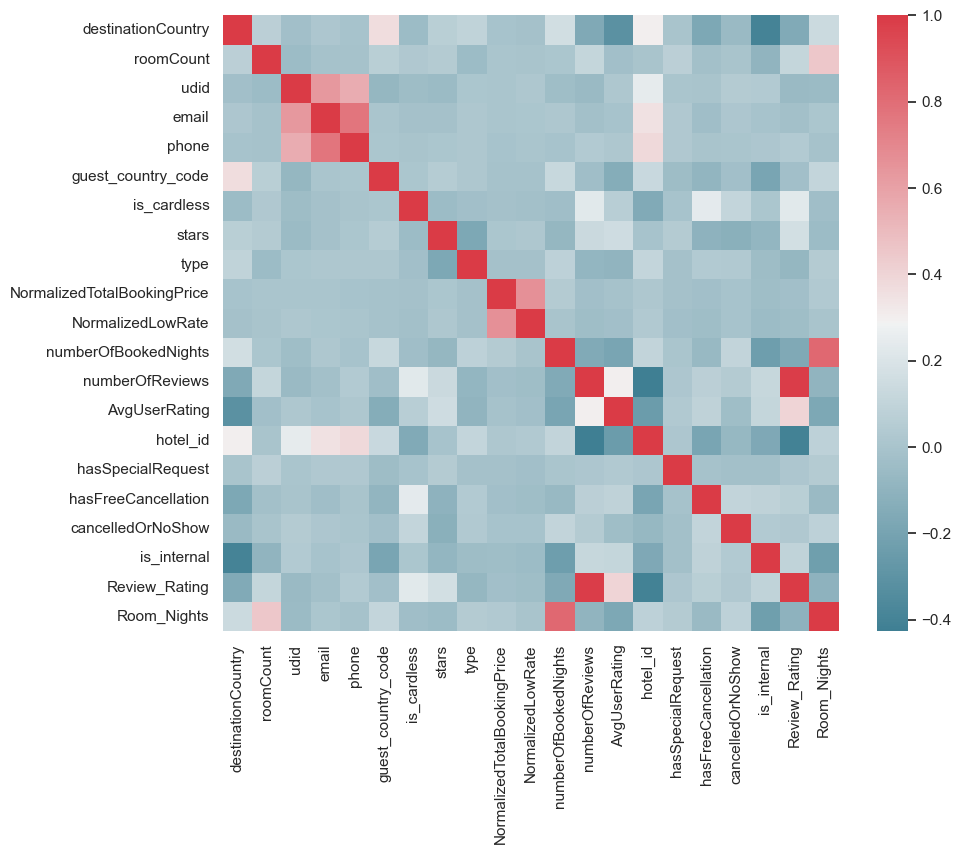

In [466]:
import seaborn as sns
sns.set()
import seaborn as sns
f, ax = plt.subplots(figsize=(10, 8))
corr = new_df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

## Apply Random Forest Classifier on the new dataframe with the new columns

In [467]:
new_df_feat = new_df[['is_cardless', 'numberOfBookedNights', 'hasFreeCancellation', 'Room_Nights']]
X_train1, X_test1, Y_train1, Y_test1 = sklearn.model_selection.train_test_split(new_df_feat, new_df['cancelledOrNoShow'],test_size=0.30, random_state=101)

In [468]:
rfc = RandomForestClassifier(n_estimators=5)
rfc.fit(X_train1, Y_train1)

RandomForestClassifier(n_estimators=5)

In [469]:
rfc_pred = rfc.predict(X_test1)
print(confusion_matrix(rfc_pred,Y_test1))
print(classification_report(rfc_pred,Y_test1))

[[817 369]
 [ 46  39]]
              precision    recall  f1-score   support

           0       0.95      0.69      0.80      1186
           1       0.10      0.46      0.16        85

    accuracy                           0.67      1271
   macro avg       0.52      0.57      0.48      1271
weighted avg       0.89      0.67      0.75      1271



# 94% Precision, Now we're at 89

# Conclusion:
### After trying multiple machine learning algorithms we found out that having good models is only as good as the data you feed it as shown by how the model improved drastically after adding 3 columns to the data set that helped find new correlations